In [3]:
import mysql.connector
from mysql.connector import errorcode
import os
import re
import time
import pandas as pd
import numpy as np
from datetime import datetime
import pyspark
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import tensorflow_io as tfio
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import sklearn
import matplotlib.pyplot as plt

import mlrose_hiive

from matplotlib import pyplot as plt




cwd = os.getcwd()

In [4]:
print(cwd)

/Users/aurimasstripeikis/Documents/Learning/OMS CS - Georgia Tech/Machine Learning - CS7641/Project 3


In [5]:
def make_cursor_for_SQLconnection():
    os.system('brew services start mysql')
    try:
      cnx = mysql.connector.connect(user='root', db='series', host='localhost')
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)

    c = cnx.cursor()
    
    return c, cnx

In [6]:
def process_parquet_version(spark):
    start_time = time.perf_counter()
    
    df_p = spark.read.format('parquet').options(header=True,inferSchema=True).load(cwd+'/stocks.parquet')
    windowSpec  = Window.partitionBy("tickers").orderBy("date")
    lag_variable = "adj_close"
    train_test_date = '2019-01-01'
    
    number_of_lags = 21
    #lag_step = 1

    
    all_sets_sdf = df_p.sort("tickers", ascending=[True])
    for lag in range(number_of_lags):
        all_sets_sdf = all_sets_sdf.withColumn(f"t-{lag+1}", pyspark.sql.functions.lag(lag_variable,lag+1).over(windowSpec))
    all_sets_sdf = all_sets_sdf.na.drop()
    
    
    
    training_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).drop('tickers')
    testing_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).drop('tickers')
    
    
    training_set_sdf = training_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing_set_sdf = testing_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    for lag in range(1,number_of_lags):
        if number_of_lags <= 1:
            break
        training_set_sdf = training_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing_set_sdf = testing_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
    
    training_set_sdf = training_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    testing_set_sdf = testing_set_sdf.drop(f"t-{number_of_lags}").na.drop()

    
    
    #print('training_set')
    #training_set_sdf.show()
    #print('testing_set')
    #testing_set_sdf.show()
    #print("Execution time:", time.perf_counter() - start_time)
    return training_set_sdf, testing_set_sdf

In [7]:
def process_parquet_version_option2(spark):
    start_time = time.perf_counter()
    
    df_p = spark.read.format('parquet').options(header=True,inferSchema=True).load(cwd+'/stocks.parquet')
    windowSpec  = Window.partitionBy("tickers").orderBy("date")
    lag_variable = "adj_close"
    train_test_date = '2020-01-01'
    
    number_of_lags = 21
    #lag_step = 1
    special_tickers = ['AAPL','MSFT','TSLA','X','IBM']
    
    
    all_sets_sdf = df_p.sort("tickers", ascending=[True])
    for lag in range(number_of_lags):
        all_sets_sdf = all_sets_sdf.withColumn(f"t-{lag+1}", pyspark.sql.functions.lag(lag_variable,lag+1).over(windowSpec))
    all_sets_sdf = all_sets_sdf.na.drop()
    df_p.unpersist()
    
    
    all_sets_sdf = all_sets_sdf.filter(all_sets_sdf.date >= '2010-01-01')
    training_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    validation_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    testing1_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    testing2_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    all_sets_sdf.unpersist()
    
    training_set_sdf = training_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    validation_set_sdf = validation_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing1_set_sdf = testing1_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing2_set_sdf = testing2_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    
    #NOTE: code below is a corner cutting workaround
    training_set_sdf = training_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    validation_set_sdf = validation_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    #NOTE: code above is a corner cutting workaround
    
    
    for lag in range(1,number_of_lags):
        if number_of_lags <= 1:
            break
        training_set_sdf = training_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        
        #NOTE: code below is a corner cutting workaround
        training_set_sdf = training_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        validation_set_sdf = validation_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        #NOTE: code above is a corner cutting workaround
    
    
    training_set_sdf = training_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    validation_set_sdf = validation_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    testing1_set_sdf = testing1_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    testing2_set_sdf = testing2_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    
    
    #print('training_set')
    #training_set_sdf.show()
    #print('testing_set')
    #validation_set_sdf.show()
    print("Execution time:", time.perf_counter() - start_time)
    return training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf

In [8]:
def process_parquet_version_option2mean(spark):
    start_time = time.perf_counter()
    
    df_p = spark.read.format('parquet').options(header=True,inferSchema=True).load(cwd+'/stocks.parquet')
    windowSpec  = Window.partitionBy("tickers").orderBy("date")
    lag_variable = "adj_close"
    train_test_date = '2020-01-01'
    
    number_of_lags = 21
    numbers_in_mean = 10
    #lag_step = 1
    special_tickers = ['AAPL','MSFT','TSLA','X','IBM']
    
    
    all_sets_sdf = df_p.sort("tickers", ascending=[True])
    for lag in range(number_of_lags+numbers_in_mean-1):
        all_sets_sdf = all_sets_sdf.withColumn(f"t-{lag+1}", pyspark.sql.functions.lag(lag_variable,lag+1).over(windowSpec))
    all_sets_sdf = all_sets_sdf.na.drop()
    df_p.unpersist()
    
    
    all_sets_sdf = all_sets_sdf.filter(all_sets_sdf.date >= '2010-01-01')
    training_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    validation_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    testing1_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    testing2_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    all_sets_sdf.unpersist()
    
    training_set_sdf = training_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    validation_set_sdf = validation_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing1_set_sdf = testing1_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing2_set_sdf = testing2_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    
    #NOTE: code below is a corner cutting workaround
    training_set_sdf = training_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    validation_set_sdf = validation_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    #NOTE: code above is a corner cutting workaround
    
    #made here to keep it in front
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    
    
    for lag in range(1,number_of_lags+numbers_in_mean-1):
        if number_of_lags+numbers_in_mean <= 1:
            break
        training_set_sdf = training_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        
        #NOTE: code below is a corner cutting workaround
        training_set_sdf = training_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        validation_set_sdf = validation_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        #NOTE: code above is a corner cutting workaround
    
    
    
    for mean_i in range(numbers_in_mean):
        training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    
    
    training_set_sdf = training_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    validation_set_sdf = validation_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    testing1_set_sdf = testing1_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    testing2_set_sdf = testing2_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    
    
    print('training_set')
    training_set_sdf.show()
    #print('testing_set')
    #validation_set_sdf.show()
    print("Execution time:", time.perf_counter() - start_time)
    return training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf

In [9]:
def process_parquet_version_option2meanIFposneg(spark, return_line = 0, START_DATE = '2015-01-01', END_DATE = None, TRAINING_TEST_DATE = '2020-01-01'):
    start_time = time.perf_counter()
    
    df_p = spark.read.format('parquet').options(header=True,inferSchema=True).load(cwd+'/stocks.parquet')
    windowSpec  = Window.partitionBy("tickers").orderBy("date")
    lag_variable = "adj_close"
    train_test_date = TRAINING_TEST_DATE
    
    number_of_lags = 21
    numbers_in_mean = 10
    #lag_step = 1
    #special_tickers = ['AAPL','MSFT','TSLA','X','IBM']
    special_tickers = ['TSLA','X']
    
    
    all_sets_sdf = df_p.sort("tickers", ascending=[True])
    for lag in range(number_of_lags+numbers_in_mean-1):
        all_sets_sdf = all_sets_sdf.withColumn(f"t-{lag+1}", pyspark.sql.functions.lag(lag_variable,lag+1).over(windowSpec))
    all_sets_sdf = all_sets_sdf.na.drop()
    df_p.unpersist()
    
    
    all_sets_sdf = all_sets_sdf.filter(all_sets_sdf.date >= START_DATE)
    if END_DATE is None:
        pass
    else:
        all_sets_sdf = all_sets_sdf.filter(all_sets_sdf.date <= END_DATE)
        
    training_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    validation_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    testing1_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    testing2_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    all_sets_sdf.unpersist()
    
    training_set_sdf = training_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    validation_set_sdf = validation_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing1_set_sdf = testing1_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing2_set_sdf = testing2_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    
    #NOTE: code below is a corner cutting workaround
    training_set_sdf = training_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    validation_set_sdf = validation_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    #NOTE: code above is a corner cutting workaround
    
    #made here to keep it in front
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    
    
    for lag in range(1,number_of_lags+numbers_in_mean-1):
        if number_of_lags+numbers_in_mean <= 1:
            break
        training_set_sdf = training_set_sdf.withColumn(f"t{lag}_-{lag+1}", ((F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).cast('float')).drop(f"t-{lag}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t{lag}_-{lag+1}", ((F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).cast('float')).drop(f"t-{lag}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t{lag}_-{lag+1}", ((F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).cast('float')).drop(f"t-{lag}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t{lag}_-{lag+1}", ((F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).cast('float')).drop(f"t-{lag}")
        
        #NOTE: code below is a corner cutting workaround
        training_set_sdf = training_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        validation_set_sdf = validation_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        #NOTE: code above is a corner cutting workaround
    
    
    #
    for mean_i in range(numbers_in_mean):
        training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    
    #drop last column that is included in mean calculations
    #dropping na values
    training_set_sdf = training_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    validation_set_sdf = validation_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    testing1_set_sdf = testing1_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    testing2_set_sdf = testing2_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    
    testing1_set_sdf.agg(F.min(F.col(f"t0_-{numbers_in_mean}")), F.max(F.col(f"t0_-{numbers_in_mean}"))).show()
    testing2_set_sdf.agg(F.min(F.col(f"t0_-{numbers_in_mean}")), F.max(F.col(f"t0_-{numbers_in_mean}"))).show()
    
    #making it into classification problem
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.when(F.col(f"t0_-{numbers_in_mean}").cast('float') > return_line, 1).otherwise(0))
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.when(F.col(f"t0_-{numbers_in_mean}").cast('float') > return_line, 1).otherwise(0))
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.when(F.col(f"t0_-{numbers_in_mean}").cast('float') > return_line, 1).otherwise(0))
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.when(F.col(f"t0_-{numbers_in_mean}").cast('float') > return_line, 1).otherwise(0))
    
    
    print('training_set')
    training_set_sdf.show()
    #print('testing_set')
    #validation_set_sdf.show()
    print("Execution time:", time.perf_counter() - start_time)
    return training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf

In [10]:
def make_parquet_version():
    print("make parquet file of the yahoo_stock_series table in SQL")
    start_time = time.perf_counter()
    cursor, connection = make_cursor_for_SQLconnection()
    cursor.execute(f"select * from yahoo_stock_series order by tickers, date asc;")
    all_stocks = cursor.fetchall()
    num_fields = len(cursor.description)
    field_names = [i[0] for i in cursor.description]
    stock_df = pd.DataFrame(all_stocks, columns = field_names)
    stock_df.to_parquet(cwd+'/stocks.parquet')
    connection.close()
    print("Execution time:", time.perf_counter() - start_time)
    return 

In [11]:
def save_processed_parquet_version(sdf, path):
    print("save processed parquet files")
    start_time = time.perf_counter()
    number_per_save = 500000
    sdf.repartition(1).write.option("maxRecordsPerFile", number_per_save).format("parquet").mode("overwrite").save(path)
    print("Execution time:", time.perf_counter() - start_time)
    return


In [12]:
def save_processed_TFRecord_version(sdf, path):
    print("save processed parquet files")
    start_time = time.perf_counter()
    number_per_save = 500000
    sdf.repartition(1).write.option("maxRecordsPerFile", number_per_save).format("tfrecords").mode("overwrite").save(path)
    print("Execution time:", time.perf_counter() - start_time)
    return


In [13]:
def read_parquet_into_pandas(t_type):
    print(f'reading {t_type} parquet file into pandas df')
    start_time = time.perf_counter()
    all_files = os.listdir(cwd+f'/{t_type}/')
    parquet_files = [cwd+f'/{t_type}/' + filename for filename in all_files if filename.endswith( '.parquet' ) ]
    df = pd.read_parquet(parquet_files)
    print("Execution time:", time.perf_counter() - start_time)
    return df

In [14]:
def pandas_into_tensorflow_df(df):
    print('making pandas dataframe into tensorflow dataset')
    start_time = time.perf_counter()
    label_list = ['t0_-1']
    features_list = [col for col in df.columns if col not in label_list + ['date','tickers']]
    #print(features_list)
    features = dict(df.loc[:,features_list].apply(pd.to_numeric, downcast='float'))
    labels = dict(df.loc[:,label_list].apply(pd.to_numeric, downcast='float'))
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    print("Execution time:", time.perf_counter() - start_time)
    return ds

In [15]:
def pandas_into_tensorflow_df2(df):
    print('making pandas dataframe into tensorflow dataset')
    start_time = time.perf_counter()
    label_list = ['t0_-10']
    features_list = [col for col in df.columns if col not in label_list + ['date','tickers']]
    #print(features_list)
    #features = list(dict(df.loc[:,features_list].apply(pd.to_numeric, downcast='float')).values())
    #labels = list(dict(df.loc[:,label_list].apply(pd.to_numeric, downcast='float')).values())
    features = df.loc[:,features_list].apply(pd.to_numeric, downcast='float').to_numpy().astype(np.float64)
    labels = df.loc[:,label_list].apply(pd.to_numeric, downcast='float').to_numpy().astype(np.float64)
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    print("Execution time:", time.perf_counter() - start_time)
    return ds

In [16]:
def create_tf_dataset(df):
    print('making pandas dataframe into tensorflow dataset')
    start_time = time.perf_counter()
    #df = spark_df.toPandas()

    x_data = []
    y_data = []
    for idx in range(len(df)):
        x_values = df.iloc[idx, 11:].values
        y_values = df.iloc[idx, 1:11].values
        y_mean = np.mean(y_values)

        x_data.append(x_values)
        y_data.append(y_mean)

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    tf_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    print("Execution time:", time.perf_counter() - start_time)
    return tf_dataset

In [17]:
def data_generator(file_paths):
    for file_path in file_paths:
        df = pd.read_parquet(file_path)

        for idx in range(len(df)-20):
            y_values = df.iloc[idx, 1:11].values
            x_values = df.iloc[idx, 11:21].values
            try:
                y_mean = y_values.mean()
            except:
                y_mean = 0


            x_values = x_values.reshape(-1, 1)

            yield x_values, y_mean

def make_dataset(t_type):
    start_time = time.perf_counter()
    all_files = os.listdir(cwd+f'/{t_type}/')
    parquet_files = [cwd+f'/{t_type}/' + filename for filename in all_files if filename.endswith( '.parquet' ) ]

    dataset = tf.data.Dataset.from_generator(
        data_generator(parquet_files),
        output_types=(tf.float32, tf.float32),
        output_shapes=((10, 1), ())
    )

    return dataset.batch(batch_size=10000)
    #val = validation_dataset.shuffle(buffer_size=10000).batch(batch_size=32)

In [18]:
def read_stocksparquet_into_pandas():
    stocks_df = pd.read_parquet('stocks.parquet')
    stocks_df.loc[(stocks.tickers.isin(['IBM','MSFT','X','TSLA','AAPL'])) & (stocks.date >= datetime.strptime('2010-01-01', '%Y-%m-%d').date()) & (stocks.date <= datetime.strptime('2020-01-01', '%Y-%m-%d').date()),:].to_parquet(cwd+'/testing_tdates_mini_values.parquet')
    stocks_df.loc[(stocks.tickers.isin(['IBM','MSFT','X','TSLA','AAPL'])) & (stocks.date >= datetime.strptime('2010-01-01', '%Y-%m-%d').date()) & (stocks.date > datetime.strptime('2020-01-01', '%Y-%m-%d').date()),:].to_parquet(cwd+'/testing_vdates_mini_values.parquet')
    return df


In [81]:
#make_parquet_version()
#spark=pyspark.sql.SparkSession.builder.appName("parquetFile").getOrCreate()
#training_set_sdf, testing_set_sdf = process_parquet_version(spark)
#save_processed_parquet_version(training_set_sdf, cwd+'/training')
#save_processed_parquet_version(validation_set_sdf, cwd+'/testing')
#save_processed_TFRecord_version(training_set_sdf, cwd+'/training_tfrecord')

#NOT USED
#DATASET 1: ['AAPL','MSFT','TSLA','X','IBM'] 2015-01-01 to present
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark)
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini')

#NOT USED
#DATASET 2: ['AAPL','MSFT','TSLA','X','IBM'] 2001-01-01 to 2005-01-01
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark, return_line = 0, START_DATE = '2000-01-01', END_DATE = '2005-01-01', TRAINING_TEST_DATE = '2020-01-01')
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini2')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini2')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini2')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini2')

#NOT USED
#DATASET 3: ['AAPL','MSFT','TSLA','X','IBM'] 2015-01-01 to present
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark, return_line = -.2, TRAINING_TEST_DATE = '2020-01-01')
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini3')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini3')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini3')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini3')

#Problem 1
#DATASET 4: ['TSLA'] TRAINING_TEST_DATE = '2012-01-01', START_DATE = '2011-01-01', END_DATE = '2013-01-01'
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark, return_line = 0, TRAINING_TEST_DATE = '2012-01-01', START_DATE = '2011-01-01', END_DATE = '2013-01-01')
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini4')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini4')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini4')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini4')

#Problem 2
#DATASET 5: ['TSLA','X'] TRAINING_TEST_DATE = '2012-01-01', START_DATE = '2011-01-01', END_DATE = '2013-01-01'
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark, return_line = 0, TRAINING_TEST_DATE = '2012-01-01', START_DATE = '2011-01-01', END_DATE = '2013-01-01')
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini5')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini5')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini5')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini5')


#training_df = read_parquet_into_pandas('training-m10-tf_mini')
#training_ds = pandas_into_tensorflow_df2(training_df)
##training_ds = create_tf_dataset(training_df)

#validation_df = read_parquet_into_pandas('validation-m10-tf_mini')
# validation_ds = pandas_into_tensorflow_df2(validation_df)
# ##testing_ds = create_tf_dataset(testing_df)

# #training_ds = make_dataset('training')
# #testing_ds = make_dataset('testing')

#testing1_df = read_parquet_into_pandas('testing-m10-tf_tdates_mini')
#testing2_df = read_parquet_into_pandas('testing-m10-tf_tdates_mini')

#Problem 1
testing1_df4 = read_parquet_into_pandas('testing-m10-tf_tdates_mini4')
testing2_df4 = read_parquet_into_pandas('testing-m10-tf_vdates_mini4')

#Problem 2
testing1_df5 = read_parquet_into_pandas('testing-m10-tf_tdates_mini5')
testing2_df5 = read_parquet_into_pandas('testing-m10-tf_vdates_mini5')

#Problem 1
#testing1_ds = pandas_into_tensorflow_df2(testing1_df4)
#testing2_ds = pandas_into_tensorflow_df2(testing2_df4)

#Problem 2
#testing1_ds2 = pandas_into_tensorflow_df2(testing1_df5)
#testing2_ds2 = pandas_into_tensorflow_df2(testing2_df5)

reading testing-m10-tf_tdates_mini4 parquet file into pandas df
Execution time: 0.0895239170640707
reading testing-m10-tf_vdates_mini4 parquet file into pandas df
Execution time: 0.004973083967342973
reading testing-m10-tf_tdates_mini5 parquet file into pandas df
Execution time: 0.0025323749287053943
reading testing-m10-tf_vdates_mini5 parquet file into pandas df
Execution time: 0.0025341250002384186


In [412]:
X_train = testing1_df4.loc[:, ~testing1_df4.columns.isin(['date','tickers','t0_-10'])]
Y_train = testing1_df4.loc[:, testing1_df4.columns.isin(['t0_-10'])]
X_val = testing2_df4.loc[:, ~testing2_df4.columns.isin(['date','tickers','t0_-10'])]
Y_val = testing2_df4.loc[:, testing2_df4.columns.isin(['t0_-10'])]

In [413]:
X_train2 = testing1_df5.loc[:, ~testing1_df5.columns.isin(['date','tickers'])]
X_train2['t0_-10'] = X_train2['t0_-10'] * (X_train2['t10_-11'].max() - X_train2['t10_-11'].min())
Y_train2 = testing1_df5.loc[:, testing1_df5.columns.isin(['tickers'])]
Y_train2['tickers'] = np.where(Y_train2['tickers']=='X', 1, 0)
X_val2 = testing2_df5.loc[:, ~testing2_df5.columns.isin(['date','tickers'])]
X_val2['t0_-10'] = X_val2['t0_-10'] * (X_val2['t10_-11'].max() - X_val2['t10_-11'].min())
Y_val2 = testing2_df5.loc[:, testing2_df5.columns.isin(['tickers'])]
Y_val2['tickers'] = np.where(Y_val2['tickers']=='X', 1, 0)

In [366]:
print(X_train2.columns)
print(X_val2.columns)

Index(['t0_-10', 't10_-11', 't11_-12', 't12_-13', 't13_-14', 't14_-15',
       't15_-16', 't16_-17', 't17_-18', 't18_-19', 't19_-20', 't20_-21',
       't21_-22', 't22_-23', 't23_-24', 't24_-25', 't25_-26', 't26_-27',
       't27_-28', 't28_-29', 't29_-30'],
      dtype='object')
Index(['t0_-10', 't10_-11', 't11_-12', 't12_-13', 't13_-14', 't14_-15',
       't15_-16', 't16_-17', 't17_-18', 't18_-19', 't19_-20', 't20_-21',
       't21_-22', 't22_-23', 't23_-24', 't24_-25', 't25_-26', 't26_-27',
       't27_-28', 't28_-29', 't29_-30'],
      dtype='object')


## Clustering Algorithms

### Expectation maximization

In [107]:
print(252-sum(Y_train['t0_-10'].tolist()))
print((252-sum(Y_train['t0_-10'].tolist()))/252)
print(sum(Y_val['t0_-10'].tolist()))

130
0.5158730158730159
129


In [112]:
from sklearn.mixture import GaussianMixture
#https://scikit-learn.org/stable/modules/mixture.html
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

#print('Weights')
#print(gm.means_)
#print()
#print('Validation sample groupings')
for cov in ['full', 'tied', 'diag', 'spherical']:
    print(cov)
    gm = GaussianMixture(n_components=2, covariance_type=cov, random_state=0).fit(X_train)
    max_train = max(sum([1 if i==j else 0 for i,j in zip(gm.predict(X_train), Y_train['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm.predict(X_train), Y_train['t0_-10'].tolist())]))
    max_val = max(sum([1 if i==j else 0 for i,j in zip(gm.predict(X_val), Y_val['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm.predict(X_val), Y_val['t0_-10'].tolist())]))
    print(f"prob1: training set grouping overlap {max_train} / {len(Y_train['t0_-10'].tolist())} = {max_train/len(Y_train['t0_-10'].tolist())}")
    print(f"prob1: validation set grouping overlap {max_val} / {len(Y_val['t0_-10'].tolist())} = {max_val/len(Y_val['t0_-10'].tolist())}")
    
    
    gm2 = GaussianMixture(n_components=2, covariance_type=cov, random_state=0).fit(X_train2)
    max_train2 = max(sum([1 if i==j else 0 for i,j in zip(gm2.predict(X_train2), Y_train2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm2.predict(X_train2), Y_train2['tickers'].tolist())]))
    max_val2 = max(sum([1 if i==j else 0 for i,j in zip(gm2.predict(X_val2), Y_val2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm2.predict(X_val2), Y_val2['tickers'].tolist())]))
    print(f"prob2: training set grouping overlap {max_train2} / {len(Y_train2['tickers'].tolist())} = {max_train2/len(Y_train2['tickers'].tolist())}")
    print(f"prob2: validation set grouping overlap {max_val2} / {len(Y_val2['tickers'].tolist())} = {max_val2/len(Y_val2['tickers'].tolist())}")

full
prob1: training set grouping overlap 138 / 252 = 0.5476190476190477
prob1: validation set grouping overlap 131 / 250 = 0.524
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping overlap 253 / 500 = 0.506
tied
prob1: training set grouping overlap 140 / 252 = 0.5555555555555556
prob1: validation set grouping overlap 131 / 250 = 0.524
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping overlap 253 / 500 = 0.506
diag
prob1: training set grouping overlap 137 / 252 = 0.5436507936507936
prob1: validation set grouping overlap 130 / 250 = 0.52
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping overlap 253 / 500 = 0.506
spherical
prob1: training set grouping overlap 143 / 252 = 0.5674603174603174
prob1: validation set grouping overlap 140 / 250 = 0.56
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping ove

### K means

In [373]:
from sklearn.cluster import KMeans

for algo in ["lloyd", "elkan"]:
    print(algo)
    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train)
    max_train = max(sum([1 if i==j else 0 for i,j in zip(kmeans.predict(X_train), Y_train['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans.predict(X_train), Y_train['t0_-10'].tolist())]))
    max_val = max(sum([1 if i==j else 0 for i,j in zip(kmeans.predict(X_val), Y_val['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans.predict(X_val), Y_val['t0_-10'].tolist())]))
    print(f"prob1: training set grouping overlap {max_train} / {len(Y_train['t0_-10'].tolist())} = {max_train/len(Y_train['t0_-10'].tolist())}")
    print(f"prob1: validation set grouping overlap {max_val} / {len(Y_val['t0_-10'].tolist())} = {max_val/len(Y_val['t0_-10'].tolist())}")
    
    kmeans2 = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train2)
    max_train2 = max(sum([1 if i==j else 0 for i,j in zip(kmeans2.predict(X_train2), Y_train2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans2.predict(X_train2), Y_train2['tickers'].tolist())]))
    max_val2 = max(sum([1 if i==j else 0 for i,j in zip(kmeans2.predict(X_val2), Y_val2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans2.predict(X_val2), Y_val2['tickers'].tolist())]))
    print(f"prob2: training set grouping overlap {max_train2} / {len(Y_train2['tickers'].tolist())} = {max_train2/len(Y_train2['tickers'].tolist())}")
    print(f"prob2: validation set grouping overlap {max_val2} / {len(Y_val2['tickers'].tolist())} = {max_val2/len(Y_val2['tickers'].tolist())}")

lloyd
prob1: training set grouping overlap 127 / 252 = 0.503968253968254
prob1: validation set grouping overlap 125 / 250 = 0.5
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping overlap 253 / 500 = 0.506
elkan
prob1: training set grouping overlap 127 / 252 = 0.503968253968254
prob1: validation set grouping overlap 125 / 250 = 0.5
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping overlap 253 / 500 = 0.506


In [39]:
kmeans2 = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_train2)
print('Cluster centers')
print(kmeans2.cluster_centers_)
print()
print('Validation sample groupings')
print(kmeans2.predict(X_val2))

Cluster centers
[[ 1.00000000e+00 -5.74338620e-03 -9.96903431e-03  7.89231829e-03
  -5.04280524e-03  4.03950859e-03 -6.93505727e-03  7.96800538e-03
  -1.91644856e-04  1.17679936e-02 -1.08485205e-02  2.22590414e-03
  -8.30475852e-03 -1.87724749e-03 -5.43479034e-03  6.69364057e-03
  -8.11908758e-03 -1.28580594e-02  1.09654114e-03  1.54338251e-02
   9.67768783e-03]
 [ 2.77555756e-16  1.16152147e-03  2.48025664e-03  5.24762735e-04
  -1.80897871e-03 -4.85855509e-04 -6.34690607e-04 -4.50873103e-04
  -2.21319062e-03 -2.23771547e-03 -7.69502806e-04 -1.63437101e-03
  -6.88682613e-04 -7.16842511e-04 -1.90007765e-03 -2.75280689e-03
  -2.23998285e-03 -7.58268804e-04 -9.23629187e-04 -1.04040368e-03
  -1.58238689e-03]
 [ 1.00000000e+00 -2.77080084e-03 -1.35124307e-03 -1.44360491e-02
   6.84936496e-03 -6.65374720e-03  5.54173608e-03 -9.88754469e-03
   4.68549936e-03 -8.06693173e-03  1.19973408e-02 -5.66003903e-04
   7.85472388e-03 -9.90876274e-04  7.38470800e-03 -4.83620187e-03
   1.01204763e-02  1.2

## Linear dimensionality reduction algorithms

## Data

<Axes: >

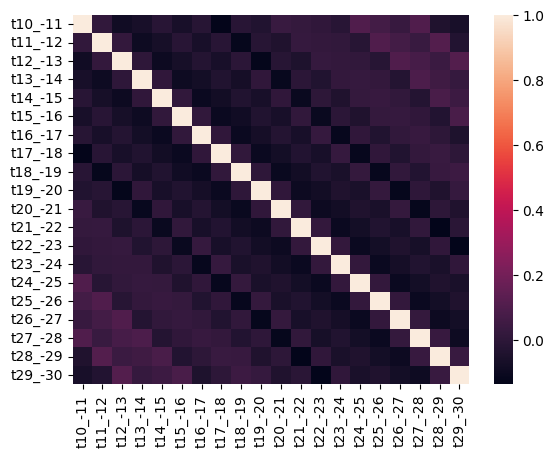

In [327]:
import seaborn as sns
sns.heatmap(X_train.corr())




<Axes: >

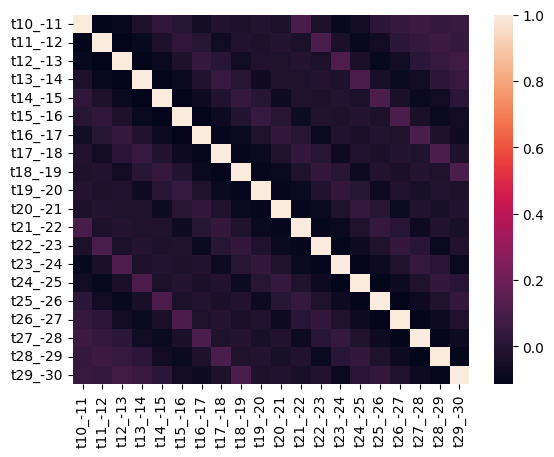

In [328]:
sns.heatmap(X_val.corr())


<Axes: >

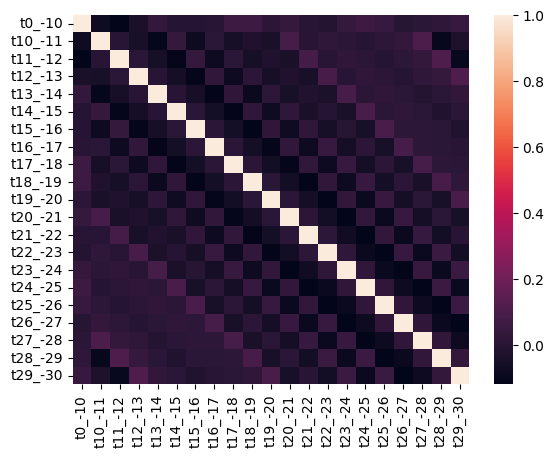

In [329]:
sns.heatmap(X_train2.corr())

<Axes: >

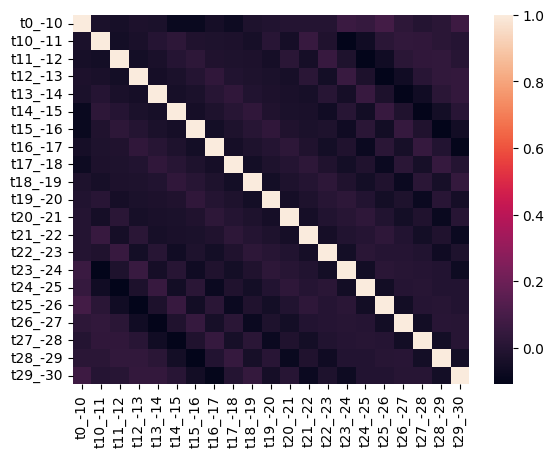

In [330]:
sns.heatmap(X_val2.corr())

### Randomized Projections

In [164]:


#cdist(X_train, X_train).unique().shape

[0.18548255 0.2231375  0.23573077 ... 0.18246515 0.19676189 0.18577102]


In [351]:
from sklearn import random_projection
import scipy

start = time.time()
#https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html#sklearn.random_projection.GaussianRandomProjection
#https://scikit-learn.org/stable/modules/random_projection.html
transformer = random_projection.GaussianRandomProjection(n_components=8)
X_train_rp = transformer.fit_transform(X_train)


X_train_dist = cdist(X_train, X_train)[np.triu_indices(X_train.shape[0], k = 1)]
X_train_rp_dist = cdist(transformer.inverse_transform(X_train_rp), transformer.inverse_transform(X_train_rp))[np.triu_indices(X_train.shape[0], k = 1)]
X_train_rp_dist = (X_train_rp_dist-min(X_train_dist))/(max(X_train_dist)-min(X_train_dist))
X_train_dist = (X_train_dist-min(X_train_dist))/(max(X_train_dist)-min(X_train_dist))
print(f'problem 1: change in average train distance from {np.average(np.abs(X_train_dist))} to {np.average(np.abs(X_train_rp_dist))}')
print(f'problem 1: average distance from train reconstructing using transform {np.average(np.abs(((X_train-transformer.inverse_transform(transformer.transform(X_train)))-X_train.min().min())/(X_train.max().max()-X_train.min().min())))}')
print(np.corrcoef(X_train_dist,X_train_rp_dist)[0][1])
print(scipy.stats.spearmanr(X_train_dist,X_train_rp_dist)[0])




X_val_dist = cdist(X_val, X_val)[np.triu_indices(X_val.shape[0], k = 1)]
X_val_rp_dist = cdist(transformer.inverse_transform(transformer.transform(X_val)), transformer.inverse_transform(transformer.transform(X_val)))[np.triu_indices(X_val.shape[0], k = 1)]
X_val_rp_dist = (X_val_rp_dist-min(X_val_dist))/(max(X_val_dist)-min(X_val_dist))
X_val_dist=(X_val_dist-min(X_val_dist))/(max(X_val_dist)-min(X_val_dist))
print(f'problem 1: change in average val distance from {np.average(np.abs(X_val_dist))} to {np.average(np.abs(X_val_rp_dist))}')
print(f'problem 1: average distance from val reconstructing using transform {np.average(np.abs(((X_val-transformer.inverse_transform(transformer.transform(X_val)))-X_val.min().min())/(X_train.max().max()-X_train.min().min())))}')
print(np.corrcoef(X_val_dist,X_val_rp_dist)[0][1])
print(scipy.stats.spearmanr(X_val_dist,X_val_rp_dist)[0])


transformer2 = random_projection.GaussianRandomProjection(n_components=8)
X_train_rp2 = transformer2.fit_transform(X_train2)

X_train_dist2 = cdist(X_train2, X_train2)[np.triu_indices(X_train2.shape[0], k = 1)]
X_train_rp_dist2 = cdist(transformer2.inverse_transform(transformer2.transform(X_train2)), transformer2.inverse_transform(transformer2.transform(X_train2)))[np.triu_indices(X_train2.shape[0], k = 1)]
X_train_rp_dist2 = (X_train_rp_dist2-min(X_train_dist2))/(max(X_train_dist2)-min(X_train_dist2))
X_train_dist2 = (X_train_dist2-min(X_train_dist2))/(max(X_train_dist2)-min(X_train_dist2))
print(f'problem 2: change in average train distance from {np.average(np.abs(X_train_dist2))} to {np.average(np.abs(X_train_rp_dist2))}')
print(f'problem 2: average distance from train reconstructing using transform {np.average(np.abs(((X_train2-transformer2.inverse_transform(transformer2.transform(X_train2)))-X_train2.min().min())/(X_train2.max().max()-X_train2.min().min())))}')
print(np.corrcoef(X_train_dist2,X_train_rp_dist2)[0][1])
print(scipy.stats.spearmanr(X_train_dist2,X_train_rp_dist2)[0])


X_val_dist2 = cdist(X_val2, X_val2)[np.triu_indices(X_val2.shape[0], k = 1)]
X_val_rp_dist2 = cdist(transformer2.inverse_transform(transformer2.transform(X_val2)), transformer2.inverse_transform(transformer2.transform(X_val2)))[np.triu_indices(X_val2.shape[0], k = 1)]
X_val_rp_dist2 = (X_val_rp_dist2-min(X_val_dist2))/(max(X_val_dist2)-min(X_val_dist2))
X_val_dist2 = (X_val_dist2-min(X_val_dist2))/(max(X_val_dist2)-min(X_val_dist2))
print(f'problem 2: change in average val distance from {np.average(np.abs(X_val_dist2))} to {np.average(np.abs(X_val_rp_dist2))}')
print(f'problem 2: average distance from val reconstructing using transform {np.average(np.abs(((X_val2-transformer2.inverse_transform(transformer2.transform(X_val2)))-X_val2.min().min())/(X_train.max().max()-X_train.min().min())))}')
print(np.corrcoef(X_val_dist2,X_val_rp_dist2)[0][1])
print(scipy.stats.spearmanr(X_val_dist2,X_val_rp_dist2)[0])

end = time.time()
print()
print(f"time it took to do random transformation: {end - start}")

problem 1: change in average train distance from 0.4216240856510895 to 0.17431885281446957
problem 1: average distance from train reconstructing using transform 0.4754321873188019
0.7360971025334471
0.7226210387089433
problem 1: change in average val distance from 0.3643237695553312 to 0.15477237131182675
problem 1: average distance from val reconstructing using transform 0.5906159281730652
0.7734124525270781
0.7504390873605601
problem 2: change in average train distance from 0.4807059340946596 to 0.22855519486233458
problem 2: average distance from train reconstructing using transform 0.32586746122526417
0.8611242335612587
0.8629994776503073
problem 2: change in average val distance from 0.5028556622780774 to 0.22015217010214766
problem 2: average distance from val reconstructing using transform 0.5994830372154952
0.8884785410148187
0.8668888616187015

time it took to do random transformation: 0.160325288772583


In [348]:
train_results = {'distance':[],'reconstruction_distance':[],'correlation':[],'spearman':[]}
val_results = {'distance':[],'reconstruction_distance':[],'correlation':[],'spearman':[]}
train_results2 = {'distance':[],'reconstruction_distance':[],'correlation':[],'spearman':[]}
val_results2 = {'distance':[],'reconstruction_distance':[],'correlation':[],'spearman':[]}

for i in range(1000):
    #print(i)
    transformer = random_projection.GaussianRandomProjection(n_components=8)
    X_train_rp = transformer.fit_transform(X_train)


    X_train_dist = cdist(X_train, X_train)[np.triu_indices(X_train.shape[0], k = 1)]
    X_train_rp_dist = cdist(transformer.inverse_transform(X_train_rp), transformer.inverse_transform(X_train_rp))[np.triu_indices(X_train.shape[0], k = 1)]
    correlation=np.corrcoef(X_train_dist,X_train_rp_dist)[0][1]
    spearman = scipy.stats.spearmanr(X_train_dist,X_train_rp_dist)[0]
    X_train_rp_dist = (X_train_rp_dist-min(X_train_dist))/(max(X_train_dist)-min(X_train_dist))
    X_train_dist = (X_train_dist-min(X_train_dist))/(max(X_train_dist)-min(X_train_dist))
    distance=np.average(np.abs(X_train_dist))-np.average(np.abs(X_train_rp_dist))
    reconstruction_distance=np.average(np.abs(((X_train-transformer.inverse_transform(transformer.transform(X_train)))-X_train.min().min())/(X_train.max().max()-X_train.min().min())))
    
    
    train_results['distance'].append(distance)
    train_results['reconstruction_distance'].append(reconstruction_distance)
    train_results['correlation'].append(correlation)
    train_results['spearman'].append(spearman)



    X_val_dist = cdist(X_val, X_val)[np.triu_indices(X_val.shape[0], k = 1)]
    X_val_rp_dist = cdist(transformer.inverse_transform(transformer.transform(X_val)), transformer.inverse_transform(transformer.transform(X_val)))[np.triu_indices(X_val.shape[0], k = 1)]
    correlation=np.corrcoef(X_val_dist,X_val_rp_dist)[0][1]
    spearman = scipy.stats.spearmanr(X_val_dist,X_val_rp_dist)[0]
    X_val_rp_dist = (X_val_rp_dist-min(X_val_dist))/(max(X_val_dist)-min(X_val_dist))
    X_val_dist=(X_val_dist-min(X_val_dist))/(max(X_val_dist)-min(X_val_dist))    
    distance=np.average(np.abs(X_val_dist))-np.average(np.abs(X_val_rp_dist))
    reconstruction_distance=np.average(np.abs(((X_val-transformer.inverse_transform(transformer.transform(X_val)))-X_train.min().min())/(X_train.max().max()-X_train.min().min())))
    
    
    val_results['distance'].append(distance)
    val_results['reconstruction_distance'].append(reconstruction_distance)
    val_results['correlation'].append(correlation)
    val_results['spearman'].append(spearman)
    

    transformer2 = random_projection.GaussianRandomProjection(n_components=8)
    X_train_rp2 = transformer2.fit_transform(X_train2)

    X_train_dist2 = cdist(X_train2, X_train2)[np.triu_indices(X_train2.shape[0], k = 1)]
    X_train_rp_dist2 = cdist(transformer2.inverse_transform(transformer2.transform(X_train2)), transformer2.inverse_transform(transformer2.transform(X_train2)))[np.triu_indices(X_train2.shape[0], k = 1)]
    correlation=np.corrcoef(X_train_dist2,X_train_rp_dist2)[0][1]
    spearman = scipy.stats.spearmanr(X_train_dist2,X_train_rp_dist2)[0]
    X_train_rp_dist2 = (X_train_rp_dist2-min(X_train_dist2))/(max(X_train_dist2)-min(X_train_dist2))
    X_train_dist2 = (X_train_dist2-min(X_train_dist2))/(max(X_train_dist2)-min(X_train_dist2))
    distance=np.average(np.abs(X_train_dist2))-np.average(np.abs(X_train_rp_dist2))
    reconstruction_distance=np.average(np.abs(((X_train2-transformer2.inverse_transform(transformer2.transform(X_train2)))-X_train2.min().min())/(X_train2.max().max()-X_train2.min().min())))
    
    
    train_results2['distance'].append(distance)
    train_results2['reconstruction_distance'].append(reconstruction_distance)
    train_results2['correlation'].append(correlation)
    train_results2['spearman'].append(spearman)


    X_val_dist2 = cdist(X_val2, X_val2)[np.triu_indices(X_val2.shape[0], k = 1)]
    X_val_rp_dist2 = cdist(transformer2.inverse_transform(transformer2.transform(X_val2)), transformer2.inverse_transform(transformer2.transform(X_val2)))[np.triu_indices(X_val2.shape[0], k = 1)]
    correlation=np.corrcoef(X_val_dist2,X_val_rp_dist2)[0][1]
    spearman = scipy.stats.spearmanr(X_val_dist2,X_val_rp_dist2)[0]
    X_val_rp_dist2 = (X_val_rp_dist2-min(X_val_dist2))/(max(X_val_dist2)-min(X_val_dist2))
    X_val_dist2 = (X_val_dist2-min(X_val_dist2))/(max(X_val_dist2)-min(X_val_dist2))
    distance=np.average(np.abs(X_val_dist2))-np.average(np.abs(X_val_rp_dist2))
    reconstruction_distance=np.average(np.abs(((X_val2-transformer2.inverse_transform(transformer2.transform(X_val2)))-X_train2.min().min())/(X_train2.max().max()-X_train2.min().min())))
    
    
    val_results2['distance'].append(distance)
    val_results2['reconstruction_distance'].append(reconstruction_distance)
    val_results2['correlation'].append(correlation)
    val_results2['spearman'].append(spearman)

[]

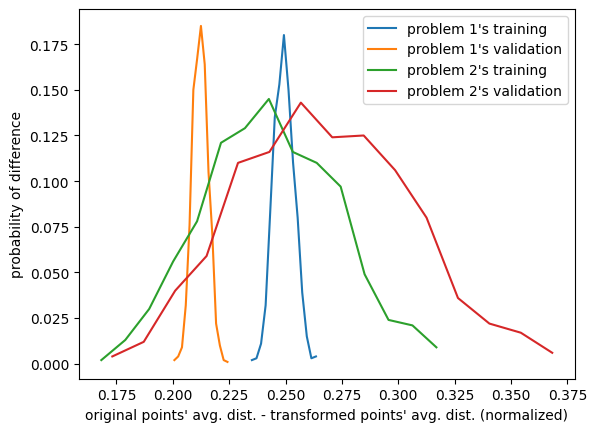

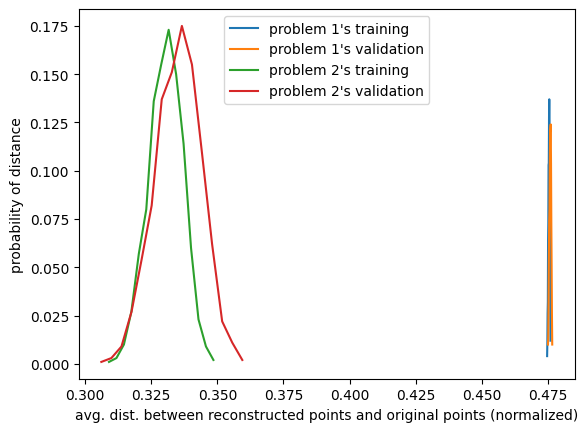

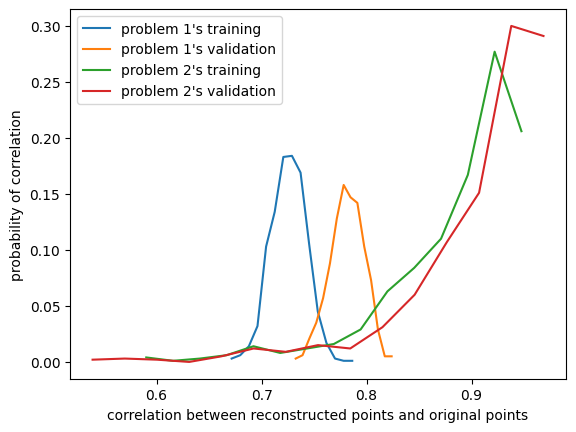

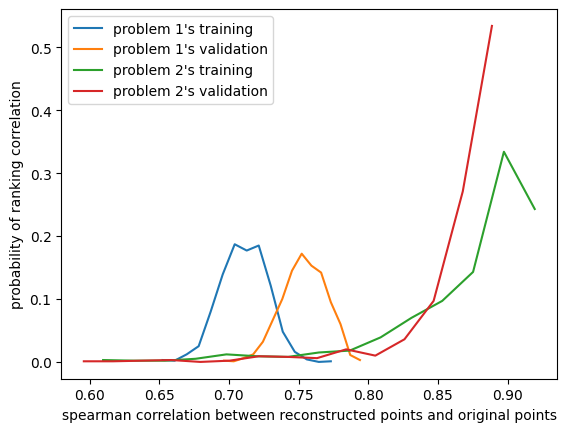

In [349]:
plt.figure()
for i, result in enumerate([train_results,val_results,train_results2,val_results2]):
    if i==0:
        name = "problem 1\'s training"
    if i==1:
        name = "problem 1\'s validation"
    if i==2:
        name = "problem 2\'s training"
    if i==3:
        name = "problem 2\'s validation"
    #distance
    count, bins_count = np.histogram(result['distance'], bins=15) 

    pdf = count / sum(count) 
    cdf = np.cumsum(pdf) 
    
    plt.plot(bins_count[1:], pdf, label=name)
    plt.xlabel('original points\' avg. dist. - transformed points\' avg. dist. (normalized)')
    plt.ylabel('probability of difference')
    plt.legend()
plt.plot()
    
plt.figure()
for i, result in enumerate([train_results,val_results,train_results2,val_results2]):
    if i==0:
        name = "problem 1\'s training"
    if i==1:
        name = "problem 1\'s validation"
    if i==2:
        name = "problem 2\'s training"
    if i==3:
        name = "problem 2\'s validation"
    #reconstruction distance
    count, bins_count = np.histogram(result['reconstruction_distance'], bins=15) 

    pdf = count / sum(count) 
    cdf = np.cumsum(pdf) 
    
    plt.plot(bins_count[1:], pdf, label=name)
    plt.xlabel('avg. dist. between reconstructed points and original points (normalized)')
    plt.ylabel('probability of distance')
    plt.legend()
plt.plot()
    
plt.figure()
for i, result in enumerate([train_results,val_results,train_results2,val_results2]):
    if i==0:
        name = "problem 1\'s training"
    if i==1:
        name = "problem 1\'s validation"
    if i==2:
        name = "problem 2\'s training"
    if i==3:
        name = "problem 2\'s validation"
    #correlation
    count, bins_count = np.histogram(result['correlation'], bins=15) 

    pdf = count / sum(count) 
    cdf = np.cumsum(pdf) 
    plt.plot(bins_count[1:], pdf, label=name)
    plt.xlabel('correlation between reconstructed points and original points')
    plt.ylabel('probability of correlation')
    plt.legend()
plt.plot()


plt.figure()
for i, result in enumerate([train_results,val_results,train_results2,val_results2]):
    if i==0:
        name = "problem 1\'s training"
    if i==1:
        name = "problem 1\'s validation"
    if i==2:
        name = "problem 2\'s training"
    if i==3:
        name = "problem 2\'s validation"
    #correlation
    count, bins_count = np.histogram(result['spearman'], bins=15) 

    pdf = count / sum(count) 
    cdf = np.cumsum(pdf) 
    plt.plot(bins_count[1:], pdf, label=name)
    plt.xlabel('spearman correlation between reconstructed points and original points')
    plt.ylabel('probability of ranking correlation')
    plt.legend()
plt.plot()

### with clustering

In [448]:
start = time.time()
#https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html#sklearn.random_projection.GaussianRandomProjection
#https://scikit-learn.org/stable/modules/random_projection.html
transformer = random_projection.GaussianRandomProjection(n_components=8)
X_train_rp = transformer.fit_transform(X_train)
X_val_rp = transformer.transform(X_val)

transformer2 = random_projection.GaussianRandomProjection(n_components=8)
X_train_rp2 = transformer2.fit_transform(X_train2)
X_val_rp2 = transformer2.transform(X_val2)

gm = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train_rp)
gm_full = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train)
max_train = max(sum([1 if i==j else 0 for i,j in zip(gm.predict(X_train_rp), Y_train['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm.predict(X_train_rp), Y_train['t0_-10'].tolist())]))
max_val = max(sum([1 if i==j else 0 for i,j in zip(gm.predict(X_val_rp), Y_val['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm.predict(X_val_rp), Y_val['t0_-10'].tolist())]))
print(f"prob1: training set grouping overlap {max_train} / {len(Y_train['t0_-10'].tolist())} = {max_train/len(Y_train['t0_-10'].tolist())}")
print(f"prob1: validation set grouping overlap {max_val} / {len(Y_val['t0_-10'].tolist())} = {max_val/len(Y_val['t0_-10'].tolist())}")
print(f"overlap with original classifications : {max(sum(gm.predict(X_val_rp)==gm_full.predict(X_val)),sum(gm.predict(X_val_rp)!=gm_full.predict(X_val)))} / {len(Y_val)}")

gm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train_rp2)
gm_full2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train2)
max_train2 = max(sum([1 if i==j else 0 for i,j in zip(gm2.predict(X_train_rp2), Y_train2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm2.predict(X_train_rp2), Y_train2['tickers'].tolist())]))
max_val2 = max(sum([1 if i==j else 0 for i,j in zip(gm2.predict(X_val_rp2), Y_val2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm2.predict(X_val_rp2), Y_val2['tickers'].tolist())]))
print(f"prob2: training set grouping overlap {max_train2} / {len(Y_train2['tickers'].tolist())} = {max_train2/len(Y_train2['tickers'].tolist())}")
print(f"prob2: validation set grouping overlap {max_val2} / {len(Y_val2['tickers'].tolist())} = {max_val2/len(Y_val2['tickers'].tolist())}")
print(f"overlap with original classifications : {max(sum(gm2.predict(X_val_rp2)==gm_full2.predict(X_val2)),sum(gm2.predict(X_val_rp2)!=gm_full2.predict(X_val2)))} / {len(Y_val2)}")
print()

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train_rp)
kmeans_full = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train)
max_train = max(sum([1 if i==j else 0 for i,j in zip(kmeans.predict(X_train_rp), Y_train['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans.predict(X_train_rp), Y_train['t0_-10'].tolist())]))
max_val = max(sum([1 if i==j else 0 for i,j in zip(kmeans.predict(X_val_rp), Y_val['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans.predict(X_val_rp), Y_val['t0_-10'].tolist())]))
print(f"prob1: training set grouping overlap {max_train} / {len(Y_train['t0_-10'].tolist())} = {max_train/len(Y_train['t0_-10'].tolist())}")
print(f"prob1: validation set grouping overlap {max_val} / {len(Y_val['t0_-10'].tolist())} = {max_val/len(Y_val['t0_-10'].tolist())}")
print(f"overlap with original classifications : {max(sum(kmeans.predict(X_val_rp)==kmeans_full.predict(X_val)),sum(kmeans.predict(X_val_rp)!=kmeans_full.predict(X_val)))} / {len(Y_val)}")

kmeans2 = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train_rp2)
kmeans_full2 = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train2)
max_train2 = max(sum([1 if i==j else 0 for i,j in zip(kmeans2.predict(X_train_rp2), Y_train2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans2.predict(X_train_rp2), Y_train2['tickers'].tolist())]))
max_val2 = max(sum([1 if i==j else 0 for i,j in zip(kmeans2.predict(X_val_rp2), Y_val2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans2.predict(X_val_rp2), Y_val2['tickers'].tolist())]))
print(f"prob2: training set grouping overlap {max_train2} / {len(Y_train2['tickers'].tolist())} = {max_train2/len(Y_train2['tickers'].tolist())}")
print(f"prob2: validation set grouping overlap {max_val2} / {len(Y_val2['tickers'].tolist())} = {max_val2/len(Y_val2['tickers'].tolist())}")
print(f"overlap with original classifications : {max(sum(kmeans2.predict(X_val_rp2)==kmeans_full2.predict(X_val2)),sum(kmeans2.predict(X_val_rp2)!=kmeans_full2.predict(X_val2)))} / {len(Y_val2)}")

prob1: training set grouping overlap 133 / 252 = 0.5277777777777778
prob1: validation set grouping overlap 127 / 250 = 0.508
overlap with original classifications : 142 / 250
prob2: training set grouping overlap 288 / 504 = 0.5714285714285714
prob2: validation set grouping overlap 252 / 500 = 0.504
overlap with original classifications : 499 / 500

prob1: training set grouping overlap 129 / 252 = 0.5119047619047619
prob1: validation set grouping overlap 127 / 250 = 0.508
overlap with original classifications : 156 / 250
prob2: training set grouping overlap 285 / 504 = 0.5654761904761905
prob2: validation set grouping overlap 253 / 500 = 0.506
overlap with original classifications : 496 / 500


### PCA

problem 1: change in average train distance from 0.4216240856510895 to 0.21862994054171678
problem 1: average distance from train reconstructing using transform 0.47438257932662964
0.8180155930384178
0.8044599568682433


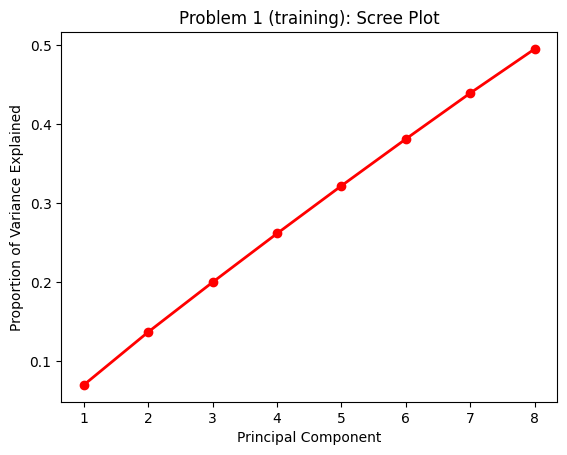

problem 1: change in average val distance from 0.3643237695553312 to 0.15199684942808775
problem 1: average distance from val reconstructing using transform 0.5894177556037903
0.7595508200200443
0.7481285243240748


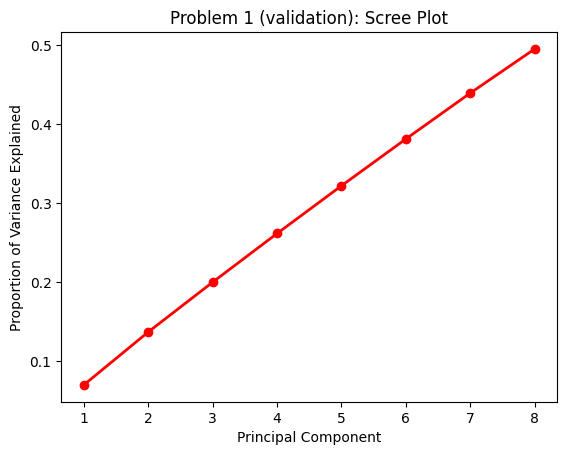

problem 2: change in average train distance from 0.4807059340946596 to 0.36901142834389955
problem 2: average distance from train reconstructing using transform 0.32174999452098907
0.9658699944049771
0.9616986917417903


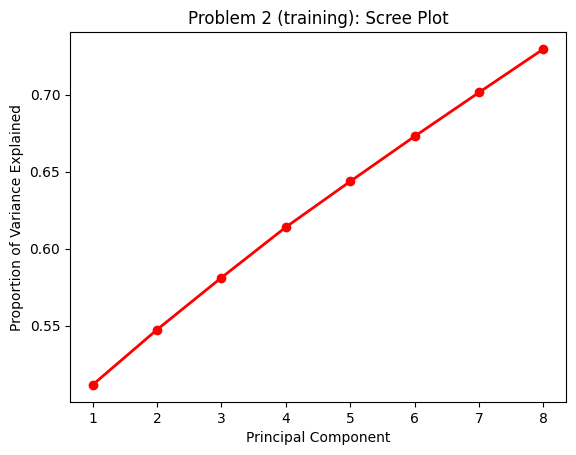

problem 2: change in average val distance from 0.5028556622780774 to 0.37724158642971867
problem 2: average distance from val reconstructing using transform 0.5917333328317711
0.9706155441397405
0.9141740475431525


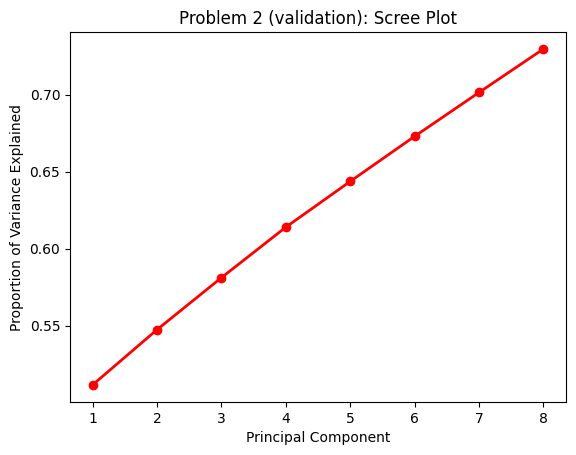

[-0.34547013 -0.2083628   0.12855946  0.25278777  0.12416162 -0.06574541
 -0.16838865  0.18665008  0.29991496  0.1035036  -0.20740612 -0.28541276
 -0.10898083  0.20489472 -0.02254782 -0.25306302 -0.2560056  -0.01937192
  0.3236742   0.3995595 ]
[ 9.98930214e-01 -1.77974748e-02 -2.70695722e-02 -1.02955547e-02
  7.92315753e-03 -1.61301761e-03 -1.35052786e-03 -1.59365009e-04
  1.40260684e-02  1.48900206e-02  2.50433358e-03  7.94566457e-03
 -1.45728040e-04 -2.66535324e-03  8.07681986e-03  1.27820741e-02
  8.80175977e-03 -7.90513989e-04  6.48846230e-04  3.89892753e-03
  9.91874601e-03]

time it took to do PCA: 0.43674516677856445


In [357]:
from sklearn.decomposition import PCA
import time

start = time.time()

transformer = PCA(n_components=8)
X_train_rp = transformer.fit_transform(X_train)


X_train_dist = cdist(X_train, X_train)[np.triu_indices(X_train.shape[0], k = 1)]
X_train_rp_dist = cdist(transformer.inverse_transform(X_train_rp), transformer.inverse_transform(X_train_rp))[np.triu_indices(X_train.shape[0], k = 1)]
X_train_rp_dist = (X_train_rp_dist-min(X_train_dist))/(max(X_train_dist)-min(X_train_dist))
X_train_dist = (X_train_dist-min(X_train_dist))/(max(X_train_dist)-min(X_train_dist))
print(f'problem 1: change in average train distance from {np.average(np.abs(X_train_dist))} to {np.average(np.abs(X_train_rp_dist))}')
print(f'problem 1: average distance from train reconstructing using transform {np.average(np.abs(((X_train-transformer.inverse_transform(transformer.transform(X_train)))-X_train.min().min())/(X_train.max().max()-X_train.min().min())))}')
print(np.corrcoef(X_train_dist,X_train_rp_dist)[0][1])
print(scipy.stats.spearmanr(X_train_dist,X_train_rp_dist)[0])

PC_values = np.arange(transformer.n_components_) + 1
cdf = np.cumsum(transformer.explained_variance_ratio_)
plt.plot(PC_values, cdf, 'ro-', linewidth=2)
plt.title('Problem 1 (training): Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()



X_val_dist = cdist(X_val, X_val)[np.triu_indices(X_val.shape[0], k = 1)]
X_val_rp_dist = cdist(transformer.inverse_transform(transformer.transform(X_val)), transformer.inverse_transform(transformer.transform(X_val)))[np.triu_indices(X_val.shape[0], k = 1)]
X_val_rp_dist = (X_val_rp_dist-min(X_val_dist))/(max(X_val_dist)-min(X_val_dist))
X_val_dist=(X_val_dist-min(X_val_dist))/(max(X_val_dist)-min(X_val_dist))
print(f'problem 1: change in average val distance from {np.average(np.abs(X_val_dist))} to {np.average(np.abs(X_val_rp_dist))}')
print(f'problem 1: average distance from val reconstructing using transform {np.average(np.abs(((X_val-transformer.inverse_transform(transformer.transform(X_val)))-X_val.min().min())/(X_train.max().max()-X_train.min().min())))}')
print(np.corrcoef(X_val_dist,X_val_rp_dist)[0][1])
print(scipy.stats.spearmanr(X_val_dist,X_val_rp_dist)[0])

PC_values = np.arange(transformer.n_components_) + 1
cdf = np.cumsum(transformer.explained_variance_ratio_)
plt.plot(PC_values, cdf, 'ro-', linewidth=2)
plt.title('Problem 1 (validation): Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()


transformer2 = PCA(n_components=8)
X_train_rp2 = transformer2.fit_transform(X_train2)

X_train_dist2 = cdist(X_train2, X_train2)[np.triu_indices(X_train2.shape[0], k = 1)]
X_train_rp_dist2 = cdist(transformer2.inverse_transform(transformer2.transform(X_train2)), transformer2.inverse_transform(transformer2.transform(X_train2)))[np.triu_indices(X_train2.shape[0], k = 1)]
X_train_rp_dist2 = (X_train_rp_dist2-min(X_train_dist2))/(max(X_train_dist2)-min(X_train_dist2))
X_train_dist2 = (X_train_dist2-min(X_train_dist2))/(max(X_train_dist2)-min(X_train_dist2))
print(f'problem 2: change in average train distance from {np.average(np.abs(X_train_dist2))} to {np.average(np.abs(X_train_rp_dist2))}')
print(f'problem 2: average distance from train reconstructing using transform {np.average(np.abs(((X_train2-transformer2.inverse_transform(transformer2.transform(X_train2)))-X_train2.min().min())/(X_train2.max().max()-X_train2.min().min())))}')
print(np.corrcoef(X_train_dist2,X_train_rp_dist2)[0][1])
print(scipy.stats.spearmanr(X_train_dist2,X_train_rp_dist2)[0])

PC_values = np.arange(transformer2.n_components_) + 1
cdf = np.cumsum(transformer2.explained_variance_ratio_)
plt.plot(PC_values, cdf, 'ro-', linewidth=2)
plt.title('Problem 2 (training): Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()


X_val_dist2 = cdist(X_val2, X_val2)[np.triu_indices(X_val2.shape[0], k = 1)]
X_val_rp_dist2 = cdist(transformer2.inverse_transform(transformer2.transform(X_val2)), transformer2.inverse_transform(transformer2.transform(X_val2)))[np.triu_indices(X_val2.shape[0], k = 1)]
X_val_rp_dist2 = (X_val_rp_dist2-min(X_val_dist2))/(max(X_val_dist2)-min(X_val_dist2))
X_val_dist2 = (X_val_dist2-min(X_val_dist2))/(max(X_val_dist2)-min(X_val_dist2))
print(f'problem 2: change in average val distance from {np.average(np.abs(X_val_dist2))} to {np.average(np.abs(X_val_rp_dist2))}')
print(f'problem 2: average distance from val reconstructing using transform {np.average(np.abs(((X_val2-transformer2.inverse_transform(transformer2.transform(X_val2)))-X_val2.min().min())/(X_train.max().max()-X_train.min().min())))}')
print(np.corrcoef(X_val_dist2,X_val_rp_dist2)[0][1])
print(scipy.stats.spearmanr(X_val_dist2,X_val_rp_dist2)[0])

PC_values = np.arange(transformer2.n_components_) + 1
cdf = np.cumsum(transformer2.explained_variance_ratio_) 
plt.plot(PC_values, cdf, 'ro-', linewidth=2)
plt.title('Problem 2 (validation): Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()


print(transformer.components_[0])
print(transformer2.components_[0])


end = time.time()
print()
print(f"time it took to do PCA: {end - start}")



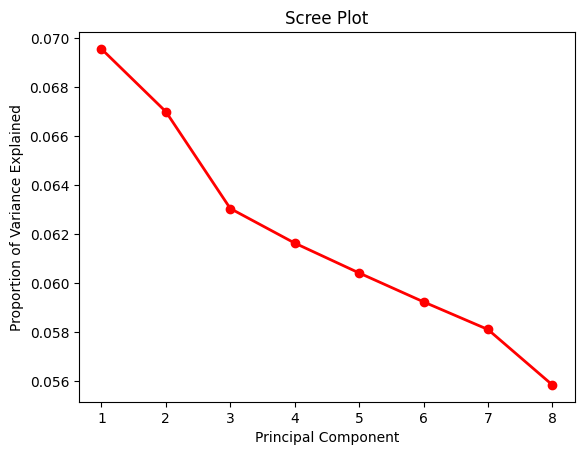

In [449]:
start = time.time()
#https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html#sklearn.random_projection.GaussianRandomProjection
#https://scikit-learn.org/stable/modules/random_projection.html
transformer = PCA(n_components=8)
X_train_rp = transformer.fit_transform(X_train)
X_val_rp = transformer.transform(X_val)

transformer2 = PCA(n_components=8)
X_train_rp2 = transformer2.fit_transform(X_train2)
X_val_rp2 = transformer2.transform(X_val2)



gm = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train_rp)
gm_full = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train)
max_train = max(sum([1 if i==j else 0 for i,j in zip(gm.predict(X_train_rp), Y_train['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm.predict(X_train_rp), Y_train['t0_-10'].tolist())]))
max_val = max(sum([1 if i==j else 0 for i,j in zip(gm.predict(X_val_rp), Y_val['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm.predict(X_val_rp), Y_val['t0_-10'].tolist())]))
print(f"prob1: training set grouping overlap {max_train} / {len(Y_train['t0_-10'].tolist())} = {max_train/len(Y_train['t0_-10'].tolist())}")
print(f"prob1: validation set grouping overlap {max_val} / {len(Y_val['t0_-10'].tolist())} = {max_val/len(Y_val['t0_-10'].tolist())}")
print(f"overlap with original classifications : {max(sum(gm.predict(X_val_rp)==gm_full.predict(X_val)),sum(gm.predict(X_val_rp)!=gm_full.predict(X_val)))} / {len(Y_val)}")

gm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train_rp2)
gm_full2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train2)
max_train2 = max(sum([1 if i==j else 0 for i,j in zip(gm2.predict(X_train_rp2), Y_train2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm2.predict(X_train_rp2), Y_train2['tickers'].tolist())]))
max_val2 = max(sum([1 if i==j else 0 for i,j in zip(gm2.predict(X_val_rp2), Y_val2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm2.predict(X_val_rp2), Y_val2['tickers'].tolist())]))
print(f"prob2: training set grouping overlap {max_train2} / {len(Y_train2['tickers'].tolist())} = {max_train2/len(Y_train2['tickers'].tolist())}")
print(f"prob2: validation set grouping overlap {max_val2} / {len(Y_val2['tickers'].tolist())} = {max_val2/len(Y_val2['tickers'].tolist())}")
print(f"overlap with original classifications : {max(sum(gm2.predict(X_val_rp2)==gm_full2.predict(X_val2)),sum(gm2.predict(X_val_rp2)!=gm_full2.predict(X_val2)))} / {len(Y_val2)}")
print()

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train_rp)
kmeans_full = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train)
max_train = max(sum([1 if i==j else 0 for i,j in zip(kmeans.predict(X_train_rp), Y_train['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans.predict(X_train_rp), Y_train['t0_-10'].tolist())]))
max_val = max(sum([1 if i==j else 0 for i,j in zip(kmeans.predict(X_val_rp), Y_val['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans.predict(X_val_rp), Y_val['t0_-10'].tolist())]))
print(f"prob1: training set grouping overlap {max_train} / {len(Y_train['t0_-10'].tolist())} = {max_train/len(Y_train['t0_-10'].tolist())}")
print(f"prob1: validation set grouping overlap {max_val} / {len(Y_val['t0_-10'].tolist())} = {max_val/len(Y_val['t0_-10'].tolist())}")
print(f"overlap with original classifications : {max(sum(kmeans.predict(X_val_rp)==kmeans_full.predict(X_val)),sum(kmeans.predict(X_val_rp)!=kmeans_full.predict(X_val)))} / {len(Y_val)}")


kmeans2 = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train_rp2)
kmeans_full2 = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train2)
max_train2 = max(sum([1 if i==j else 0 for i,j in zip(kmeans2.predict(X_train_rp2), Y_train2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans2.predict(X_train_rp2), Y_train2['tickers'].tolist())]))
max_val2 = max(sum([1 if i==j else 0 for i,j in zip(kmeans2.predict(X_val_rp2), Y_val2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans2.predict(X_val_rp2), Y_val2['tickers'].tolist())]))
print(f"prob2: training set grouping overlap {max_train2} / {len(Y_train2['tickers'].tolist())} = {max_train2/len(Y_train2['tickers'].tolist())}")
print(f"prob2: validation set grouping overlap {max_val2} / {len(Y_val2['tickers'].tolist())} = {max_val2/len(Y_val2['tickers'].tolist())}")
print(f"overlap with original classifications : {max(sum(kmeans2.predict(X_val_rp2)==kmeans_full2.predict(X_val2)),sum(kmeans2.predict(X_val_rp2)!=kmeans_full2.predict(X_val2)))} / {len(Y_val2)}")

prob1: training set grouping overlap 135 / 252 = 0.5357142857142857
prob1: validation set grouping overlap 136 / 250 = 0.544
overlap with original classifications : 127 / 250
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping overlap 253 / 500 = 0.506
overlap with original classifications : 500 / 500

prob1: training set grouping overlap 134 / 252 = 0.5317460317460317
prob1: validation set grouping overlap 133 / 250 = 0.532
overlap with original classifications : 148 / 250
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping overlap 253 / 500 = 0.506
overlap with original classifications : 500 / 500


### Independent Component Analysis

In [361]:
from sklearn.decomposition import FastICA
import time
from scipy.stats import norm, kurtosis

start = time.time()

transformer = FastICA(n_components=8,
        random_state=0,
        whiten='unit-variance')
X_train_rp = transformer.fit_transform(X_train)


X_train_dist = cdist(X_train, X_train)[np.triu_indices(X_train.shape[0], k = 1)]
X_train_rp_dist = cdist(transformer.inverse_transform(X_train_rp), transformer.inverse_transform(X_train_rp))[np.triu_indices(X_train.shape[0], k = 1)]
X_train_rp_dist = (X_train_rp_dist-min(X_train_dist))/(max(X_train_dist)-min(X_train_dist))
X_train_dist = (X_train_dist-min(X_train_dist))/(max(X_train_dist)-min(X_train_dist))
print(f'problem 1: change in average train distance from {np.average(np.abs(X_train_dist))} to {np.average(np.abs(X_train_rp_dist))}')
print(f'problem 1: average distance from train reconstructing using transform {np.average(np.abs(((X_train-transformer.inverse_transform(transformer.transform(X_train)))-X_train.min().min())/(X_train.max().max()-X_train.min().min())))}')
print(np.corrcoef(X_train_dist,X_train_rp_dist)[0][1])
print(scipy.stats.spearmanr(X_train_dist,X_train_rp_dist)[0])

# PC_values = np.arange(transformer.n_components_) + 1
# cdf = np.cumsum(transformer.explained_variance_ratio_)
# plt.plot(PC_values, cdf, 'ro-', linewidth=2)
# plt.title('Problem 1 (training): Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Proportion of Variance Explained')
# plt.show()



X_val_dist = cdist(X_val, X_val)[np.triu_indices(X_val.shape[0], k = 1)]
X_val_rp_dist = cdist(transformer.inverse_transform(transformer.transform(X_val)), transformer.inverse_transform(transformer.transform(X_val)))[np.triu_indices(X_val.shape[0], k = 1)]
X_val_rp_dist = (X_val_rp_dist-min(X_val_dist))/(max(X_val_dist)-min(X_val_dist))
X_val_dist=(X_val_dist-min(X_val_dist))/(max(X_val_dist)-min(X_val_dist))
print(f'problem 1: change in average val distance from {np.average(np.abs(X_val_dist))} to {np.average(np.abs(X_val_rp_dist))}')
print(f'problem 1: average distance from val reconstructing using transform {np.average(np.abs(((X_val-transformer.inverse_transform(transformer.transform(X_val)))-X_val.min().min())/(X_train.max().max()-X_train.min().min())))}')
print(np.corrcoef(X_val_dist,X_val_rp_dist)[0][1])
print(scipy.stats.spearmanr(X_val_dist,X_val_rp_dist)[0])

# PC_values = np.arange(transformer.n_components_) + 1
# cdf = np.cumsum(transformer.explained_variance_ratio_)
# plt.plot(PC_values, cdf, 'ro-', linewidth=2)
# plt.title('Problem 1 (validation): Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Proportion of Variance Explained')
# plt.show()


transformer2 = FastICA(n_components=8,
        random_state=0,
        whiten='unit-variance')
X_train_rp2 = transformer2.fit_transform(X_train2)

X_train_dist2 = cdist(X_train2, X_train2)[np.triu_indices(X_train2.shape[0], k = 1)]
X_train_rp_dist2 = cdist(transformer2.inverse_transform(transformer2.transform(X_train2)), transformer2.inverse_transform(transformer2.transform(X_train2)))[np.triu_indices(X_train2.shape[0], k = 1)]
X_train_rp_dist2 = (X_train_rp_dist2-min(X_train_dist2))/(max(X_train_dist2)-min(X_train_dist2))
X_train_dist2 = (X_train_dist2-min(X_train_dist2))/(max(X_train_dist2)-min(X_train_dist2))
print(f'problem 2: change in average train distance from {np.average(np.abs(X_train_dist2))} to {np.average(np.abs(X_train_rp_dist2))}')
print(f'problem 2: average distance from train reconstructing using transform {np.average(np.abs(((X_train2-transformer2.inverse_transform(transformer2.transform(X_train2)))-X_train2.min().min())/(X_train2.max().max()-X_train2.min().min())))}')
print(np.corrcoef(X_train_dist2,X_train_rp_dist2)[0][1])
print(scipy.stats.spearmanr(X_train_dist2,X_train_rp_dist2)[0])

# PC_values = np.arange(transformer2.n_components_) + 1
# cdf = np.cumsum(transformer2.explained_variance_ratio_)
# plt.plot(PC_values, cdf, 'ro-', linewidth=2)
# plt.title('Problem 2 (training): Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Proportion of Variance Explained')
# plt.show()


X_val_dist2 = cdist(X_val2, X_val2)[np.triu_indices(X_val2.shape[0], k = 1)]
X_val_rp_dist2 = cdist(transformer2.inverse_transform(transformer2.transform(X_val2)), transformer2.inverse_transform(transformer2.transform(X_val2)))[np.triu_indices(X_val2.shape[0], k = 1)]
X_val_rp_dist2 = (X_val_rp_dist2-min(X_val_dist2))/(max(X_val_dist2)-min(X_val_dist2))
X_val_dist2 = (X_val_dist2-min(X_val_dist2))/(max(X_val_dist2)-min(X_val_dist2))
print(f'problem 2: change in average val distance from {np.average(np.abs(X_val_dist2))} to {np.average(np.abs(X_val_rp_dist2))}')
print(f'problem 2: average distance from val reconstructing using transform {np.average(np.abs(((X_val2-transformer2.inverse_transform(transformer2.transform(X_val2)))-X_val2.min().min())/(X_train.max().max()-X_train.min().min())))}')
print(np.corrcoef(X_val_dist2,X_val_rp_dist2)[0][1])
print(scipy.stats.spearmanr(X_val_dist2,X_val_rp_dist2)[0])

# PC_values = np.arange(transformer2.n_components_) + 1
# cdf = np.cumsum(transformer2.explained_variance_ratio_) 
# plt.plot(PC_values, cdf, 'ro-', linewidth=2)
# plt.title('Problem 2 (validation): Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Proportion of Variance Explained')
# plt.show()


# print(kurtosis(X_train))
# print(kurtosis(X_val))
# print(kurtosis(X_train2))
# print(kurtosis(X_val2))
# print(transformer.components_)

end = time.time()
print()
print(f"time it took to do PCA: {end - start}")



problem 1: change in average train distance from 0.4216240856510895 to 0.21862992696024408
problem 1: average distance from train reconstructing using transform 0.47438257932662964
0.818015469103442
0.804459913965588
problem 1: change in average val distance from 0.3643237695553312 to 0.15199692250177277
problem 1: average distance from val reconstructing using transform 0.5894177556037903
0.7595506887125888
0.7481286107883967
problem 2: change in average train distance from 0.4807059340946596 to 0.36901142834389955
problem 2: average distance from train reconstructing using transform 0.32174999452098907
0.9658699944049771
0.9616986917417903
problem 2: change in average val distance from 0.5028556622780774 to 0.37724158642971894
problem 2: average distance from val reconstructing using transform 0.5917333328317712
0.9706155441397404
0.9141740475431525
[4.0553308 3.9830132 3.9616542 3.8609166 3.8427296 3.8295975 3.9996543
 3.9740157 3.9134178 3.8990622 3.8925743 3.7804694 3.784058  3.76

In [450]:
start = time.time()
#https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html#sklearn.random_projection.GaussianRandomProjection
#https://scikit-learn.org/stable/modules/random_projection.html
transformer = FastICA(n_components=8,
        random_state=0,
        whiten='unit-variance')
X_train_rp = transformer.fit_transform(X_train)
X_val_rp = transformer.transform(X_val)

transformer2 = FastICA(n_components=8,
        random_state=0,
        whiten='unit-variance')
X_train_rp2 = transformer2.fit_transform(X_train2)
X_val_rp2 = transformer2.transform(X_val2)

gm = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train_rp)
gm_full = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train)
max_train = max(sum([1 if i==j else 0 for i,j in zip(gm.predict(X_train_rp), Y_train['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm.predict(X_train_rp), Y_train['t0_-10'].tolist())]))
max_val = max(sum([1 if i==j else 0 for i,j in zip(gm.predict(X_val_rp), Y_val['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm.predict(X_val_rp), Y_val['t0_-10'].tolist())]))
print(f"prob1: training set grouping overlap {max_train} / {len(Y_train['t0_-10'].tolist())} = {max_train/len(Y_train['t0_-10'].tolist())}")
print(f"prob1: validation set grouping overlap {max_val} / {len(Y_val['t0_-10'].tolist())} = {max_val/len(Y_val['t0_-10'].tolist())}")
print(f"overlap with original classifications : {max(sum(gm.predict(X_val_rp)==gm_full.predict(X_val)),sum(gm.predict(X_val_rp)!=gm_full.predict(X_val)))} / {len(Y_val)}")


gm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train_rp2)
gm_full2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_train2)
max_train2 = max(sum([1 if i==j else 0 for i,j in zip(gm2.predict(X_train_rp2), Y_train2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm2.predict(X_train_rp2), Y_train2['tickers'].tolist())]))
max_val2 = max(sum([1 if i==j else 0 for i,j in zip(gm2.predict(X_val_rp2), Y_val2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(gm2.predict(X_val_rp2), Y_val2['tickers'].tolist())]))
print(f"prob2: training set grouping overlap {max_train2} / {len(Y_train2['tickers'].tolist())} = {max_train2/len(Y_train2['tickers'].tolist())}")
print(f"prob2: validation set grouping overlap {max_val2} / {len(Y_val2['tickers'].tolist())} = {max_val2/len(Y_val2['tickers'].tolist())}")
print(f"overlap with original classifications : {max(sum(gm2.predict(X_val_rp2)==gm_full2.predict(X_val2)),sum(gm2.predict(X_val_rp2)!=gm_full2.predict(X_val2)))} / {len(Y_val2)}")

print()

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train_rp)
kmeans_full = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train)
max_train = max(sum([1 if i==j else 0 for i,j in zip(kmeans.predict(X_train_rp), Y_train['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans.predict(X_train_rp), Y_train['t0_-10'].tolist())]))
max_val = max(sum([1 if i==j else 0 for i,j in zip(kmeans.predict(X_val_rp), Y_val['t0_-10'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans.predict(X_val_rp), Y_val['t0_-10'].tolist())]))
print(f"prob1: training set grouping overlap {max_train} / {len(Y_train['t0_-10'].tolist())} = {max_train/len(Y_train['t0_-10'].tolist())}")
print(f"prob1: validation set grouping overlap {max_val} / {len(Y_val['t0_-10'].tolist())} = {max_val/len(Y_val['t0_-10'].tolist())}")
print(f"overlap with original classifications : {max(sum(kmeans.predict(X_val_rp)==kmeans_full.predict(X_val)),sum(kmeans.predict(X_val_rp)!=kmeans_full.predict(X_val)))} / {len(Y_val)}")


kmeans2 = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train_rp2)
kmeans_full2 = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train2)
max_train2 = max(sum([1 if i==j else 0 for i,j in zip(kmeans2.predict(X_train_rp2), Y_train2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans2.predict(X_train_rp2), Y_train2['tickers'].tolist())]))
max_val2 = max(sum([1 if i==j else 0 for i,j in zip(kmeans2.predict(X_val_rp2), Y_val2['tickers'].tolist())]),sum([0 if i==j else 1 for i,j in zip(kmeans2.predict(X_val_rp2), Y_val2['tickers'].tolist())]))
print(f"prob2: training set grouping overlap {max_train2} / {len(Y_train2['tickers'].tolist())} = {max_train2/len(Y_train2['tickers'].tolist())}")
print(f"prob2: validation set grouping overlap {max_val2} / {len(Y_val2['tickers'].tolist())} = {max_val2/len(Y_val2['tickers'].tolist())}")
print(f"overlap with original classifications : {max(sum(kmeans2.predict(X_val_rp2)==kmeans_full2.predict(X_val2)),sum(kmeans2.predict(X_val_rp2)!=kmeans_full2.predict(X_val2)))} / {len(Y_val2)}")

prob1: training set grouping overlap 126 / 252 = 0.5
prob1: validation set grouping overlap 131 / 250 = 0.524
overlap with original classifications : 134 / 250
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping overlap 253 / 500 = 0.506
overlap with original classifications : 500 / 500

prob1: training set grouping overlap 127 / 252 = 0.503968253968254
prob1: validation set grouping overlap 136 / 250 = 0.544
overlap with original classifications : 149 / 250
prob2: training set grouping overlap 287 / 504 = 0.5694444444444444
prob2: validation set grouping overlap 253 / 500 = 0.506
overlap with original classifications : 500 / 500


In [66]:
from sklearn.decomposition import FastICA
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html
transformer = FastICA(n_components=8,
        random_state=0,
        whiten='unit-variance')

X_transformed = transformer.fit_transform(X_train)
print(transformer.components_)
print('Validation sample groupings')
print(transformer.transform(X_val))

[[  0.2915432   14.44165     -2.4587882    1.2926       2.782112
    5.261897    -3.1477852    0.35807595 -13.617062     1.1510469
   -1.614418     0.9661041   -2.2229078   -0.4086701   -2.8019865
   14.468344     1.3273311    0.19287543   2.5461824   -1.1402954 ]
 [ -4.488133    -4.851487     3.4847548    2.455785     2.8774652
   11.217546    -2.7583447   -2.9513538    2.6327808    3.1592517
   -0.849784    -2.2301154  -14.308306    -1.5362809    1.0333688
    1.8797145    2.0592926   -0.50992256  -2.2120054   14.293917  ]
 [  3.210477    -3.3729544   -6.5768294   -2.5312684    6.0952325
    2.1926587    8.43046     -2.6265254    0.10516409   3.0868626
    8.1491      -0.3963832   -3.4308188  -16.91247     -5.441799
   -2.007438     3.6854932    6.440365     6.7998757   -3.651808  ]
 [  3.8063416   -3.2177708   -1.323776    -2.779878    -9.346015
    6.41906      2.4080284   -3.8935864   -3.6532316   -0.22413075
    1.6635627   13.90256     -1.0579611   -0.7518579   -1.5371653
   -0.

## Neural Network

In [374]:
def initialize_inception_model():
    x_input = tf.keras.Input(shape=(20,1))
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(20,1))(x_input)
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(20,1))(x_input)
    conv_1 = tf.expand_dims(x_input,-1)
    conv_2a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2b1)
    conv_2c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2c1)
    conv_2d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_2 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_2b2,conv_2c2,conv_2d2])
    conv_3a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3b1)
    conv_3c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3c1)
    conv_3d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_3 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_3a,conv_3b2,conv_3c2,conv_3d2,concat_2])
    output = tf.keras.layers.Flatten()(concat_3)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(30, activation=tf.keras.layers.ReLU())(output)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    print(conv_2a.shape)
    print(conv_2b2.shape)
    print(conv_2c2.shape)
    print(conv_2d2.shape)
    print(concat_2.shape)
      
    return tf.keras.Model(inputs = x_input, outputs = output)

    

In [388]:
def initialize_inception_model_smaller():
    x_input = tf.keras.Input(shape=(8,1))
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(8,1))(x_input)
    conv_1 = tf.expand_dims(x_input,-1)
    conv_2a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2b1)
    conv_2c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2c1)
    conv_2d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_2 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_2b2,conv_2c2,conv_2d2])
    conv_3a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3b1)
    conv_3c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3c1)
    conv_3d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_3 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_3a,conv_3b2,conv_3c2,conv_3d2,concat_2])
    output = tf.keras.layers.Flatten()(concat_3)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(30, activation=tf.keras.layers.ReLU())(output)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    print(conv_2a.shape)
    print(conv_2b2.shape)
    print(conv_2c2.shape)
    print(conv_2d2.shape)
    print(concat_2.shape)
      
    return tf.keras.Model(inputs = x_input, outputs = output)

    

In [415]:
def initialize_inception_model_larger():
    x_input = tf.keras.Input(shape=(21,1))
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(21,1))(x_input)
    conv_1 = tf.expand_dims(x_input,-1)
    conv_2a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2b1)
    conv_2c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2c1)
    conv_2d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_2 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_2b2,conv_2c2,conv_2d2])
    conv_3a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3b1)
    conv_3c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3c1)
    conv_3d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_3 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_3a,conv_3b2,conv_3c2,conv_3d2,concat_2])
    output = tf.keras.layers.Flatten()(concat_3)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(30, activation=tf.keras.layers.ReLU())(output)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    print(conv_2a.shape)
    print(conv_2b2.shape)
    print(conv_2c2.shape)
    print(conv_2d2.shape)
    print(concat_2.shape)
      
    return tf.keras.Model(inputs = x_input, outputs = output)

    

In [414]:
transformer_random = random_projection.GaussianRandomProjection(n_components=8)
transformer_random.fit_transform(X_train)
transformer_pca = PCA(n_components=8)
transformer_pca.fit_transform(X_train)
transformer_ica = FastICA(n_components=8,
        random_state=0,
        whiten='unit-variance')
transformer_ica.fit_transform(X_train)

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto", algorithm=algo).fit(X_train)


gm = GaussianMixture(n_components=2, covariance_type=cov, random_state=0).fit(X_train)

X_train_kmeans = X_train.copy()
X_train_kmeans['k_means'] = kmeans.predict(X_train)
X_val_kmeans = X_val.copy()
X_val_kmeans['k_means'] = kmeans.predict(X_val)

X_train_gm = X_train.copy()
X_train_gm['k_means'] = gm.predict(X_train)
X_val_gm = X_val.copy()
X_val_gm['k_means'] = gm.predict(X_val)

In [428]:
start = time.time()
model = initialize_inception_model_smaller()
#tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
#tf.keras.optimizers.legacy.SGD(learning_rate = .001, clipvalue=10000)
model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])

train_ds = tf.data.Dataset.from_tensor_slices((transformer_ica.transform(X_train), Y_train))
val_ds = tf.data.Dataset.from_tensor_slices((transformer_ica.transform(X_val), Y_val))
hist_ica = model.fit(train_ds.batch(200), validation_data = val_ds.batch(200), epochs=100, verbose=0)
end = time.time()
print()
print(f"time it took to run model: {end - start}")

(None, 8, 1, 10)
(None, 8, 1, 10)
(None, 8, 1, 10)
(None, 8, 1, 10)
(None, 32, 1, 10)

time it took to run model: 2.103541851043701


(252, 2)


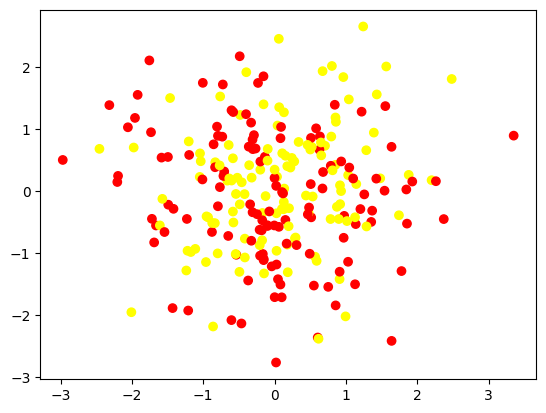

In [437]:
ica_train = transformer_ica.transform(X_train)
ica_val = transformer_ica.transform(X_train)

transformer_final = PCA(n_components=2)
ica_final = transformer_final.fit_transform(ica)



plt.scatter(ica_final[:,0], ica_final[:,1], c=Y_train.values.tolist(), cmap=plt.cm.autumn)

In [430]:

print(hist.history['accuracy']) #2.96
print()
print((hist_random.history['accuracy'])) #2.24
print()
print((hist_pca.history['accuracy'])) #3.53
print()
print(hist_ica.history['accuracy']) #2.1
print()
print((hist_gm.history['accuracy'])) #3.09
print()
print((hist_kmeans.history['accuracy'])) #3.24

[0.4722222089767456, 0.5357142686843872, 0.511904776096344, 0.4960317313671112, 0.4801587164402008, 0.4523809552192688, 0.4761904776096344, 0.488095223903656, 0.5079365372657776, 0.4761904776096344, 0.460317462682724, 0.488095223903656, 0.5079365372657776, 0.4404761791229248, 0.4960317313671112, 0.4920634925365448, 0.4722222089767456, 0.4920634925365448, 0.4801587164402008, 0.5158730149269104, 0.488095223903656, 0.511904776096344, 0.5515872836112976, 0.488095223903656, 0.4722222089767456, 0.4642857015132904, 0.488095223903656, 0.5039682388305664, 0.460317462682724, 0.511904776096344, 0.4761904776096344, 0.460317462682724, 0.5039682388305664, 0.5079365372657776, 0.4801587164402008, 0.5079365372657776, 0.4920634925365448, 0.5158730149269104, 0.488095223903656, 0.4841269850730896, 0.4682539701461792, 0.4801587164402008, 0.4761904776096344, 0.4920634925365448, 0.4404761791229248, 0.4920634925365448, 0.5039682388305664, 0.4642857015132904, 0.4722222089767456, 0.4761904776096344, 0.507936537

# STOP

In [37]:
#for p in training_ds.take(1):
#    print(p)
#for p in testing_ds.batch(1024).take(1):
#    print(p[1])

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([ 0.00816041,  0.00327485,  0.00611909,  0.02237729, -0.01981132,
       -0.00749064, -0.01407801,  0.00533643,  0.01603017, -0.01095827,
       -0.01152339,  0.00509613, -0.0199773 , -0.00451977, -0.03024326,
       -0.02873563, -0.00381679, -0.03833605, -0.02135302,  0.01581188])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.04024052])>)
tf.Tensor(
[[ 0.00750983]
 [-0.01609087]
 [ 0.00300625]
 ...
 [ 0.02263648]
 [-0.05989583]
 [-0.04016621]], shape=(1024, 1), dtype=float64)


In [112]:
class PrecisionCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_loss = logs.get('loss')
        train_mae = logs.get('mae')
        val_loss = logs.get('val_loss')
        val_mae = logs.get('val_mae')

        if train_loss is not None and train_mae is not None and val_loss is not None and val_mae is not None:
            print(f'Epoch {epoch + 1}: '
                  f'train_loss: {train_loss:.5f}, '
                  f'train_mae: {train_mae:.5f}, '
                  f'val_loss: {val_loss:.5f}, '
                  f'val_mae: {val_mae:.5f}')

In [21]:
def evaluate_model(model, model_inputs):
    model.evaluate(model_inputs.loc[:,~model_inputs.columns.isin(['t0_-10','t0_-1','date','tickers'])].astype(np.float64),model_inputs.loc[:,model_inputs.columns.isin(['t0_-10','t0_-1'])].astype(np.float64))

## MODELS

In [52]:
def initialize_inception_model():
    x_input = tf.keras.Input(shape=(20,1))
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(20,1))(x_input)
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(20,1))(x_input)
    conv_1 = tf.expand_dims(x_input,-1)
    conv_2a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2b1)
    conv_2c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2c1)
    conv_2d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_2 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_2b2,conv_2c2,conv_2d2])
    conv_3a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3b1)
    conv_3c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3c1)
    conv_3d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_3 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_3a,conv_3b2,conv_3c2,conv_3d2,concat_2])
    output = tf.keras.layers.Flatten()(concat_3)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(30, activation=tf.keras.layers.ReLU())(output)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    print(conv_2a.shape)
    print(conv_2b2.shape)
    print(conv_2c2.shape)
    print(conv_2d2.shape)
    print(concat_2.shape)
      
    return tf.keras.Model(inputs = x_input, outputs = output)

    

In [79]:
def initialize_model():
    x_input = tf.keras.Input(shape=(20,1))
    print(x_input.shape)
    #tf.keras.layers.LeakyReLU(alpha=0.2)
    #N, T, F
    conv_1 = tf.keras.layers.Conv1D(filters=30,kernel_size=5,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=(20,1))(x_input)
    print(conv_1.shape)
    conv_1 = tf.expand_dims(conv_1,-1)
    #N, W, H, C for Conv2D
    conv_2 = tf.keras.layers.Conv2D(filters=30,kernel_size=5,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_1.shape)(conv_1)
    print(conv_2.shape)
    conv_3 = tf.keras.layers.Conv2D(filters=30,kernel_size=5,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_2.shape[1:2])(conv_2)
    print(conv_3.shape)
    conv_4 = tf.keras.layers.Conv2D(filters=30,kernel_size=5,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_3.shape[1:2])(conv_3)
    #conv_5 = tf.keras.layers.Conv2D(filters=20,kernel_size=3,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_4.shape[1:2])(conv_4)
    #conv_6 = tf.keras.layers.Conv2D(filters=20,kernel_size=3,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_5.shape[1:2])(conv_5)
    #conv_7 = tf.keras.layers.Conv2D(filters=20,kernel_size=3,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_6.shape[1:2])(conv_6)
    print(conv_4.shape)
    output = tf.keras.layers.Flatten()(conv_3)
    output = tf.keras.layers.Dropout(.22)(output)
    output = tf.keras.layers.Dense(30, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(output)
    output = tf.keras.layers.Dropout(.22)(output)
    output = tf.keras.layers.Dense(1, activation='linear')(output)
    print(output.shape)
    
    return tf.keras.Model(inputs = x_input, outputs = output)

model = initialize_model()
#tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
#tf.keras.optimizers.legacy.SGD(learning_rate = .001, clipvalue=10000)
model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.000001), loss='mse', metrics=['mae'])
#print(training_ds[0].shape)

(None, 20, 1)
(None, 16, 30)
(None, 12, 26, 30)
(None, 8, 22, 30)
(None, 4, 18, 30)
(None, 1)


In [ ]:
plt.scatter(waterUsage['duration'], waterUsage['water_amount'],\
            c=waterUsage['third_column'], cmap=plt.cm.autumn)

In [ ]:
def positional_encoding(pos, d_model):
    def get_angles(position, i, d_model):
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    angle_rads = get_angles(np.arange(pos)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Add()([x, inputs])

    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)
    x = tf.keras.layers.Add()([x, inputs])
    return x


inputs = tf.keras.layers.Input(shape=(20, 1))
#pos_encoding = positional_encoding(20, 32)  
x = inputs# + pos_encoding

x = transformer_encoder(x, head_size=256, num_heads=8, ff_dim=256, dropout=0.3)
x = transformer_encoder(x, head_size=256, num_heads=8, ff_dim=256, dropout=0.3)
x = transformer_encoder(x, head_size=256, num_heads=8, ff_dim=256, dropout=0.3)
x = transformer_encoder(x, head_size=256, num_heads=8, ff_dim=256, dropout=0.3)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)
model.compile(optimizer=optim, loss='mae', metrics=['mse'])


epochs = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='non_m_10_model_epoch_{epoch:02d}.hdf5',
    save_freq='epoch',
    save_best_only=False,  
    save_weights_only=False,
    monitor='val_loss',
    verbose=1
)



history = model.fit(
    training_ds.batch(1024),
    epochs=epochs,
    validation_data=validation_ds.batch(1024),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]  
)

Epoch 1/10
  649/12648 [>.............................] - ETA: 9:55:59 - loss: 0.0243 - mse: 0.0289

In [90]:
def initialize_LSTM_model():
    x_input = tf.keras.Input(shape=(20,1))
    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), input_shape=x_input.shape)(x_input)
    lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), input_shape=lstm_1.shape)(lstm_1)
    lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), input_shape=lstm_2.shape)(lstm_2)
    #print(lstm_3.shape)
    output = tf.keras.layers.Dropout(.20)(lstm_3)
    output = tf.keras.layers.Dense(64)(output)
    output = tf.keras.layers.Dropout(.20)(output)
    output = tf.keras.layers.Dense(32)(output)
    output = tf.keras.layers.Dense(1)(output)
    print(output.shape)
    
    return tf.keras.Model(inputs = x_input, outputs = output)

In [91]:
model = initialize_LSTM_model()

(None, 20, 1)


In [92]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.000001), loss='mse', metrics=['mae'])

In [93]:
#hist = model.fit(training_ds.batch(4096), validation_data = validation_ds.batch(4096), epochs=10, verbose=1)

In [94]:
hist = model.fit(training_ds.batch(4096), validation_data = validation_ds.batch(4096), epochs=10, verbose=1)

Epoch 1/10
3162/3162 [==============================] - 1538s 485ms/step - loss: 0.0283 - mae: 0.0240 - val_loss: 0.0321 - val_mae: 0.0293
Epoch 2/10
3162/3162 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.0240

KeyboardInterrupt: 

In [64]:
name = 'LSTM32_br-LSTM32_br-drop20-d30'
model.save_weights(cwd+f'/checkpoints_noexploding2/{name}')

hist_df = pd.DataFrame(hist.history)
hist_json_file = cwd+'/histories2/'+f'{name}.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
print(model.summary())

NameError: name 'hist' is not defined

In [31]:
evaluate_model(model, testing1_df)
evaluate_model(model, testing2_df)

389/389 [==============================] - 1s 3ms/step - loss: 0.0154 - mse: 5.6789e-04


In [46]:
our_portfolio, average_portfolio = simulate_portfolio(model,testing2_df)
graph_portfoliocomparison_noncumulativereturns(our_portfolio, average_portfolio)

389/389 [==============================] - 2s 4ms/step


ValueError: Must pass 2-d input. shape=(1, 20, 1)

In [52]:
#model = tf.keras.models.load_model(cwd+f'/checkpoints_noexploding2/{name}.keras')

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 20, 1)]              0         []                            
                                                                                                  
 tf.expand_dims_21 (TFOpLam  (None, 20, 1, 1)             0         ['input_23[0][0]']            
 bda)                                                                                             
                                                                                                  
 conv2d_104 (Conv2D)         (None, 20, 1, 10)            20        ['tf.expand_dims_21[0][0]']   
                                                                                                  
 conv2d_106 (Conv2D)         (None, 20, 1, 10)            20        ['tf.expand_dims_21[0][0

In [87]:
x_ = validation_df.loc[0::1000000,~validation_df.columns.isin(['date','tickers','t0_-1'])].astype(np.float64)
y_ = validation_df.loc[0::1000000,validation_df.columns.isin(['t0_-1'])]
#print(x_)

y_h = model.predict([x_])
print(y_h)
print(y_)

1/1 [==============================] - 1s 673ms/step
[[[ 1.78698159e-04]
  [ 7.86808232e-05]
  [-6.44687825e-05]
  [-1.36901959e-04]
  [-2.19791487e-04]
  [-2.17297173e-04]
  [-1.38856340e-04]
  [-3.02711815e-05]
  [-1.62269534e-05]
  [-4.67857317e-05]
  [-9.35334974e-05]
  [-1.17260388e-04]
  [-1.22781727e-04]
  [-1.09450317e-04]
  [-7.87325407e-05]
  [-3.53433497e-05]
  [ 2.51493730e-05]
  [ 8.34010571e-05]
  [ 9.34927011e-05]
  [ 8.18310364e-05]]

 [[ 8.60091604e-05]
  [ 9.64068022e-05]
  [ 1.04935651e-04]
  [ 1.11797402e-04]
  [ 1.17187912e-04]
  [ 1.21287361e-04]
  [ 1.24255021e-04]
  [ 1.26226674e-04]
  [ 1.27313455e-04]
  [ 1.27601699e-04]
  [ 1.27153005e-04]
  [ 1.26004190e-04]
  [ 1.24167345e-04]
  [ 1.21629448e-04]
  [ 1.18351352e-04]
  [ 1.14266571e-04]
  [ 1.09279266e-04]
  [ 1.03261948e-04]
  [ 9.60528632e-05]
  [ 8.74537218e-05]]

 [[-1.82313641e-04]
  [-2.58470944e-04]
  [-3.46336339e-04]
  [-5.39860048e-04]
  [-8.44717957e-04]
  [-1.25348475e-03]
  [-1.59297127e-03]
  [

In [49]:
model.evaluate(x_,y_)

1/1 [==============================] - 0s 11ms/step - loss: 4.7831e-05 - mae: 0.0069


[4.7831454139668494e-05, 0.0068623400293290615]

In [52]:
pred_v = np.array([[-0.00735895, -0.03624901, -0.02571977, -0.04368576,  0.01755697, -0.03042376,
  -0.00396825, -0.03144654,  0.02727925,  0.02426471, -0.00910747,  0.04135053,
  -0.01236418, -0.00706845,  0.11767152,  0.02166525,  0.02170139,  0.02536716,
  -0.05349621,  0.05090748],])
print(model.weights[0])
print((pred_v)[None,:,:].shape)
y_h = model.predict(pred_v)
print(y_h)

<tf.Variable 'conv1d_3/kernel:0' shape=(5, 1, 5) dtype=float32, numpy=
array([[[-0.2502947 , -0.08063756, -1.8757702 , -0.1538194 ,
         -2.735259  ]],

       [[-0.2185082 , -0.09377079, -4.153501  , -0.02860929,
         -3.69378   ]],

       [[-0.26184344, -0.05476932, -2.9104345 , -0.05799996,
         -1.2728422 ]],

       [[-0.24259545, -0.02105638, -1.2699478 , -0.2430043 ,
         -0.8758068 ]],

       [[-0.31347042, -0.10521723, -0.26818496, -0.22857463,
         -0.9506155 ]]], dtype=float32)>
(1, 1, 20)
1/1 [==============================] - 0s 56ms/step
[[0.6538664]]


In [59]:
testing1_df = read_parquet_into_pandas('testing_tdates_mini')
testing2_df = read_parquet_into_pandas('testing_vdates_mini')
#print(testing2_df)

reading testing_tdates_mini parquet file into pandas df
Execution time: 0.08669820900013292
reading testing_vdates_mini parquet file into pandas df
Execution time: 0.025034665999555727


In [88]:
def simulate_portfolio(model, model_inputs):
    y_h = model.predict(model_inputs.loc[:,~model_inputs.columns.isin(['t0_-10','t0_-1','date','tickers'])].astype(np.float64))
    inputs_w_outputs = model_inputs.loc[:,model_inputs.columns.isin(['date','t0_-1','t0_-10','tickers'])].rename(columns={'t0_-1':'change','t0_-10':'change'})
    inputs_w_outputs['predictions'] = y_h
    
    print(inputs_w_outputs.shape)
    print(inputs_w_outputs)    
    inputs_w_outputs = inputs_w_outputs.pivot_table(index = 'date', columns='tickers', values = ['predictions','change'])
    i_s = inputs_w_outputs['predictions'].idxmax(axis=1, skipna=True, numeric_only=False)
    
    
    ticker_i_mapping = {}
    for i, ticker in enumerate(inputs_w_outputs['predictions'].columns):
        if ticker != 'date':
            ticker_i_mapping[ticker] = i

    our_portfolio = pd.DataFrame(data = {'date' : inputs_w_outputs['change'].index, 'portfolio_change' : inputs_w_outputs['change'].values[np.arange(len(i_s.map(ticker_i_mapping))),i_s.map(ticker_i_mapping)]}).set_index('date')
    average_portfolio = pd.DataFrame(data = {'date' : inputs_w_outputs['change'].index, 'portfolio_change' : inputs_w_outputs['change'].mean(axis=1)}).set_index('date')
    
    return our_portfolio, average_portfolio

def graph_portfoliocomparison_noncumulativereturns(our_portfolio, baseline_portfolio):
    our_portfolio['portfolio_change+1'] = our_portfolio['portfolio_change']+1
    baseline_portfolio['portfolio_change+1'] = baseline_portfolio['portfolio_change']+1
    our_portfolio['portfolio_change_cumulative'] = our_portfolio['portfolio_change+1'].cumprod()
    baseline_portfolio['portfolio_change_cumulative'] = baseline_portfolio['portfolio_change+1'].cumprod()
    
    print(our_portfolio)
    
    plt.figure(figsize=(12,5))
    plt.ylabel('Cumulative Return Factor')

    ax1 = our_portfolio.portfolio_change_cumulative.plot(color='blue', grid=True, label='Our Portfolio')
    ax2 = baseline_portfolio.portfolio_change_cumulative.plot(color='red', grid=True, secondary_y=False, label='Baseline Portfolio')

    h1, l1 = ax1.get_legend_handles_labels()
    #h2, l2 = ax2.get_legend_handles_labels()


    #plt.legend(h1+h2, l1+l2, loc=2)
    plt.legend(h1, l1, loc=2)
    plt.show()
    


In [89]:
our_portfolio, average_portfolio = simulate_portfolio(model,testing2_df)
graph_portfoliocomparison_noncumulativereturns(our_portfolio, average_portfolio)

389/389 [==============================] - 2s 3ms/step
(12437, 4)


ValueError: Shape of passed values is (4, 40, 1), indices imply (10, 4)

In [ ]:
def simulate_portflio(expectations_df, prices_df):
    expectations_df.loc[:,expectations_df[~validation_df.columns.isin(['date','tickers','t0_-1'].idxmax:
    
        

In [6]:
d = {'x' : [1,2], 'y' : [3,4]}
print(dict(d.map(lambda x: (x['x'], x['y']))))


AttributeError: 'dict' object has no attribute 'map'